In [1]:
from neupy import environment
import csv
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.nn import Module
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import math
np.random.seed(42)

In [2]:
dfTrain = pd.read_csv('data/train.csv', sep=',')
dfTest = pd.read_csv('data/test.csv', sep=',')

dfTrain_ = dfTrain.assign(Type = pd.Series(np.zeros(dfTrain.shape[0]) + 0).values) # 0 Train
dfTest_ = dfTest.assign(Type = pd.Series(np.zeros(dfTest.shape[0]) + 1).values) # 1 Test

dfAll = pd.concat([dfTrain_, dfTest_], ignore_index=True)
dfAll.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,Type
count,2310.000000,2310.000000,2310.0,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2.310000e+03,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000
mean,124.913853,123.417316,9.0,0.014334,0.004714,1.893939,5.709320,2.424723,8.243692e+00,37.051595,32.821308,44.187879,34.145599,-12.690861,21.408850,-8.717989,45.137470,0.426893,-1.362897,0.909091
std,72.956532,57.483851,0.0,0.040154,0.024234,2.698908,44.846457,3.610084,5.881152e+01,38.176410,35.036774,43.527461,36.364773,11.583562,19.571819,11.551628,42.921764,0.228309,1.545335,0.287542
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175,0.000000
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.355555,0.777780,4.216373e-01,7.296296,7.000000,9.555555,6.027778,-18.555555,4.138889,-16.777779,11.555555,0.284235,-2.188057,1.000000
50%,121.000000,122.000000,9.0,0.000000,0.000000,1.222224,0.833333,1.444444,9.629633e-01,21.592592,19.555555,27.666667,20.333334,-10.888889,19.666666,-10.888889,28.666666,0.374803,-2.051200,1.000000
75%,189.000000,172.000000,9.0,0.000000,0.000000,2.166667,1.806367,2.555556,2.183269e+00,53.212964,47.333332,64.888890,46.500001,-4.222222,35.777780,-3.222222,64.888890,0.540123,-1.562308,1.000000
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480,1.000000


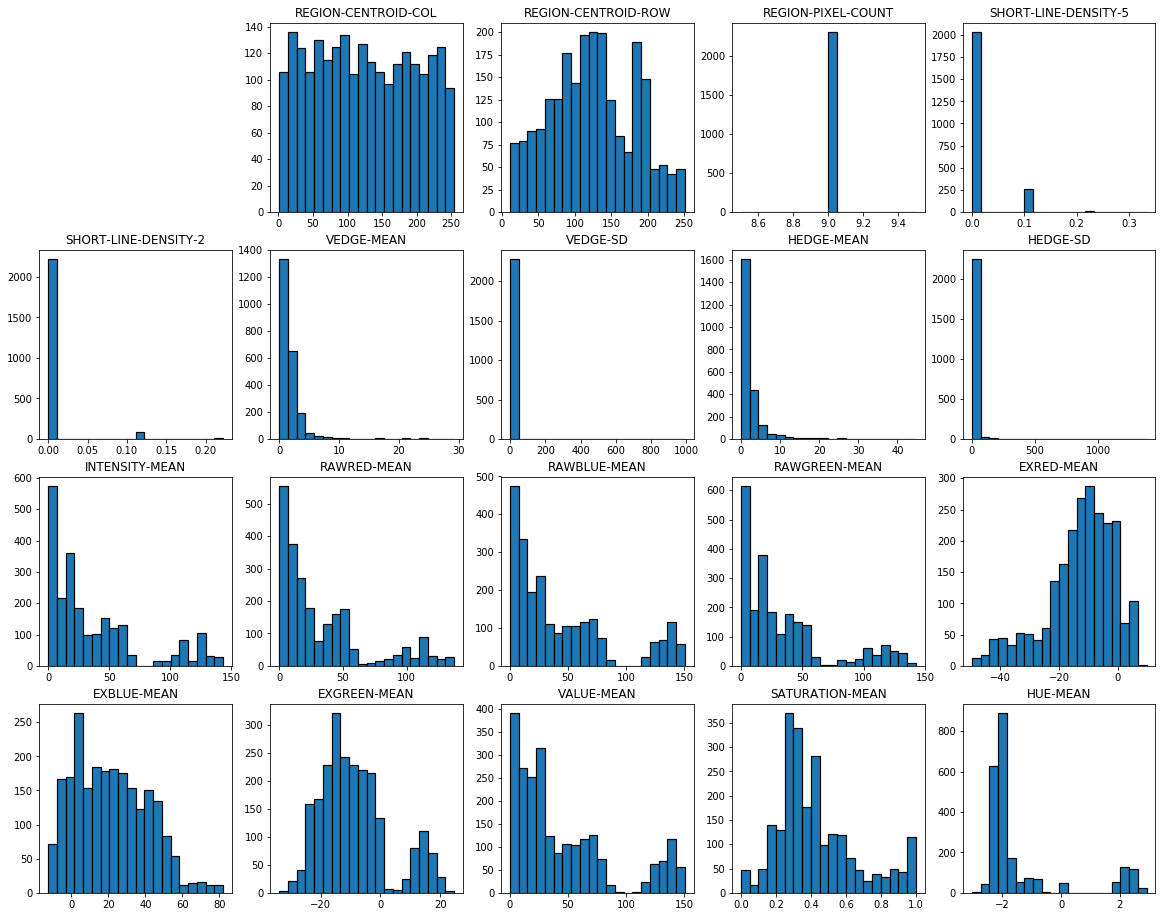

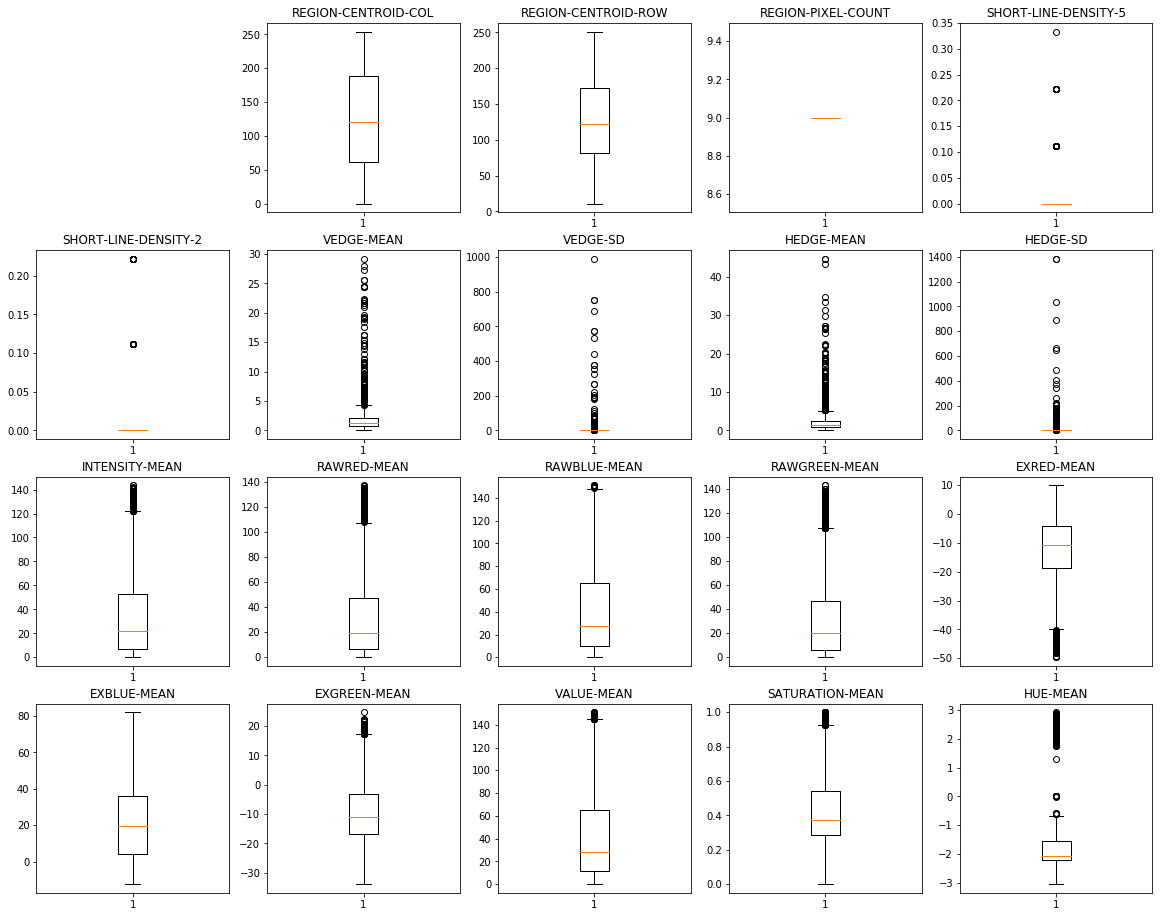

In [3]:
def showGistogram(df):
    plt.figure(figsize = (20, 16))
    for i in range(1, len(df.columns) - 1):
        plt.subplot(4, 5, i+1)
        plt.title(df.columns[i])
        plt.hist(df[df.columns[i]], 20, edgecolor='black', linewidth=1.2)
    plt.savefig('gists.png', bbox_inches='tight')
    plt.show()

def showBox(df):
    plt.figure(figsize = (20, 16))
    for i in range(1, len(df.columns) - 1):
        plt.subplot(4, 5, i+1)
        plt.title(df.columns[i])
        plt.boxplot(df[df.columns[i]])
    plt.savefig('boxes.png', bbox_inches='tight')
    plt.show()
        
showGistogram(dfAll)
showBox(dfAll)

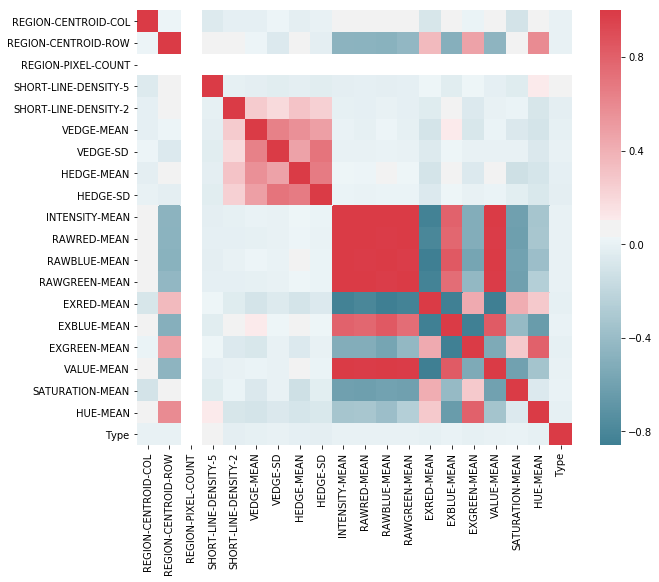

In [4]:
f, ax = plt.subplots(figsize=(10, 8))
corr = dfAll.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.savefig('heatmap.png', bbox_inches='tight')
plt.show()

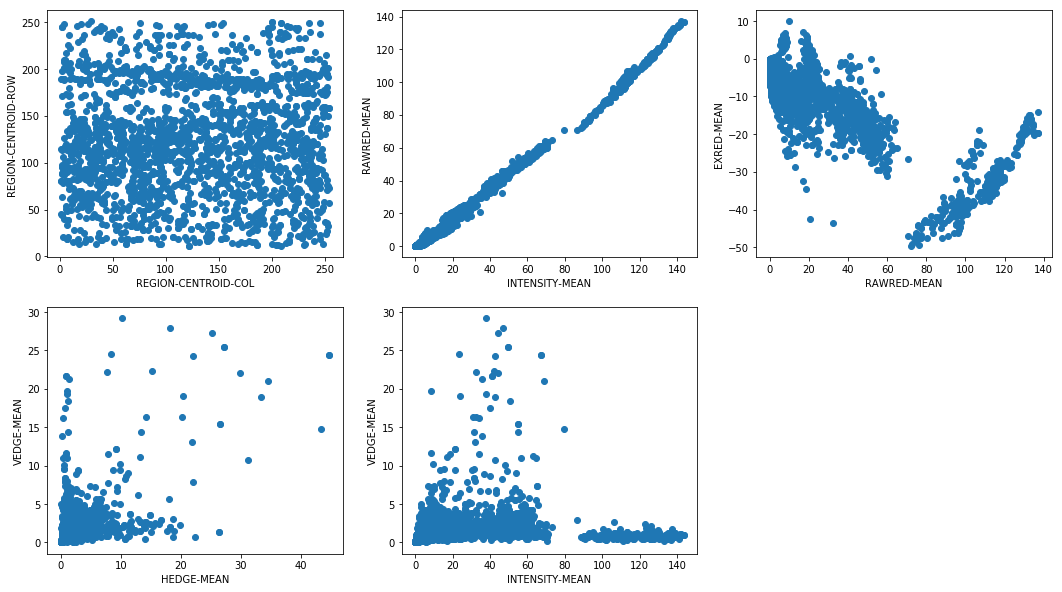

In [5]:
def showScatters(df):
    plt.figure(figsize = (18, 10))

    plt.subplot(2, 3, 1)
    plt.xlabel(df.columns[1])
    plt.ylabel(df.columns[2])
    plt.scatter(df[df.columns[1]], df[df.columns[2]])

    plt.subplot(2, 3, 2)
    plt.xlabel('INTENSITY-MEAN')
    plt.ylabel('RAWRED-MEAN')
    plt.scatter(df['INTENSITY-MEAN'], df['RAWRED-MEAN'])

    plt.subplot(2, 3, 3)
    plt.xlabel('RAWRED-MEAN')
    plt.ylabel('EXRED-MEAN')
    plt.scatter(df['RAWRED-MEAN'], df['EXRED-MEAN'])

    plt.subplot(2, 3, 4)
    plt.xlabel('HEDGE-MEAN')
    plt.ylabel('VEDGE-MEAN')
    plt.scatter(df['HEDGE-MEAN'], df['VEDGE-MEAN'])

    plt.subplot(2, 3, 5)
    plt.xlabel('INTENSITY-MEAN')
    plt.ylabel('VEDGE-MEAN')
    plt.scatter(df['INTENSITY-MEAN'], df['VEDGE-MEAN'])

    plt.savefig('scatters.png', bbox_inches='tight')
    plt.show()

showScatters(dfAll)

In [6]:
dfAll = dfAll.drop_duplicates(keep='first')

In [7]:
# типо удаление выбросов

filt_df = dfAll.loc[:, dfAll.columns != 'CLASS']
low = .01
high = .99
quant_df = filt_df.quantile([low, high])
#print(quant_df)

filt_df = filt_df.apply(lambda x: x[(x >= quant_df.loc[low,x.name]) & 
                                    (x <= quant_df.loc[high,x.name])], axis=0)

filt_df = pd.concat([dfAll.loc[:,'CLASS'], filt_df], axis=1)
filt_df.dropna(inplace=True)

In [8]:
filt_df.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,Type
count,1988.000000,1988.000000,1988.0,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000
mean,123.614185,123.034708,9.0,0.012911,0.003465,1.631847,1.895365,2.084256,3.657738,35.644813,31.552258,42.853846,32.528337,-12.277666,21.627096,-9.349430,43.627264,0.434846,-1.449154,0.906942
std,71.036871,54.682340,0.0,0.035616,0.019319,1.524557,5.390786,2.324740,12.297167,36.998170,33.832065,42.286344,35.203737,11.156528,18.627328,10.845714,41.791405,0.234813,1.437591,0.290587
min,4.000000,15.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-44.666668,-9.666667,-28.111110,0.000000,0.000000,-2.519165,0.000000
25%,63.000000,83.000000,9.0,0.000000,0.000000,0.666667,0.344266,0.777777,0.389683,6.620370,6.555555,9.000000,4.416667,-18.222221,5.000000,-17.222221,10.444445,0.283992,-2.166343,1.000000
50%,119.000000,122.000000,9.0,0.000000,0.000000,1.222222,0.829629,1.388889,0.928958,21.296297,19.388890,27.777779,19.277777,-10.444445,20.000000,-11.444445,28.444445,0.380425,-2.051801,1.000000
75%,186.250000,165.250000,9.0,0.000000,0.000000,2.111112,1.765145,2.444445,2.107602,51.675927,46.333332,64.027779,45.333332,-4.000000,36.555557,-3.777778,64.027779,0.545855,-1.633857,1.000000
max,251.000000,245.000000,9.0,0.111111,0.111111,16.222223,84.877770,18.666666,131.807390,136.296300,129.888890,146.444440,132.777790,5.333334,71.333336,19.222221,146.444440,1.000000,2.628208,1.000000


In [9]:
dfAllFilt = filt_df
#dfTrainFilt = dfAllFilt[dfAllFilt.Type == 0]
#dfTestFilt = dfAllFilt[dfAllFilt.Type == 1]
print(dfAllFilt.shape[0])
#print(dfTrainFilt.shape[0])
#print(dfTestFilt.shape[0])

1988


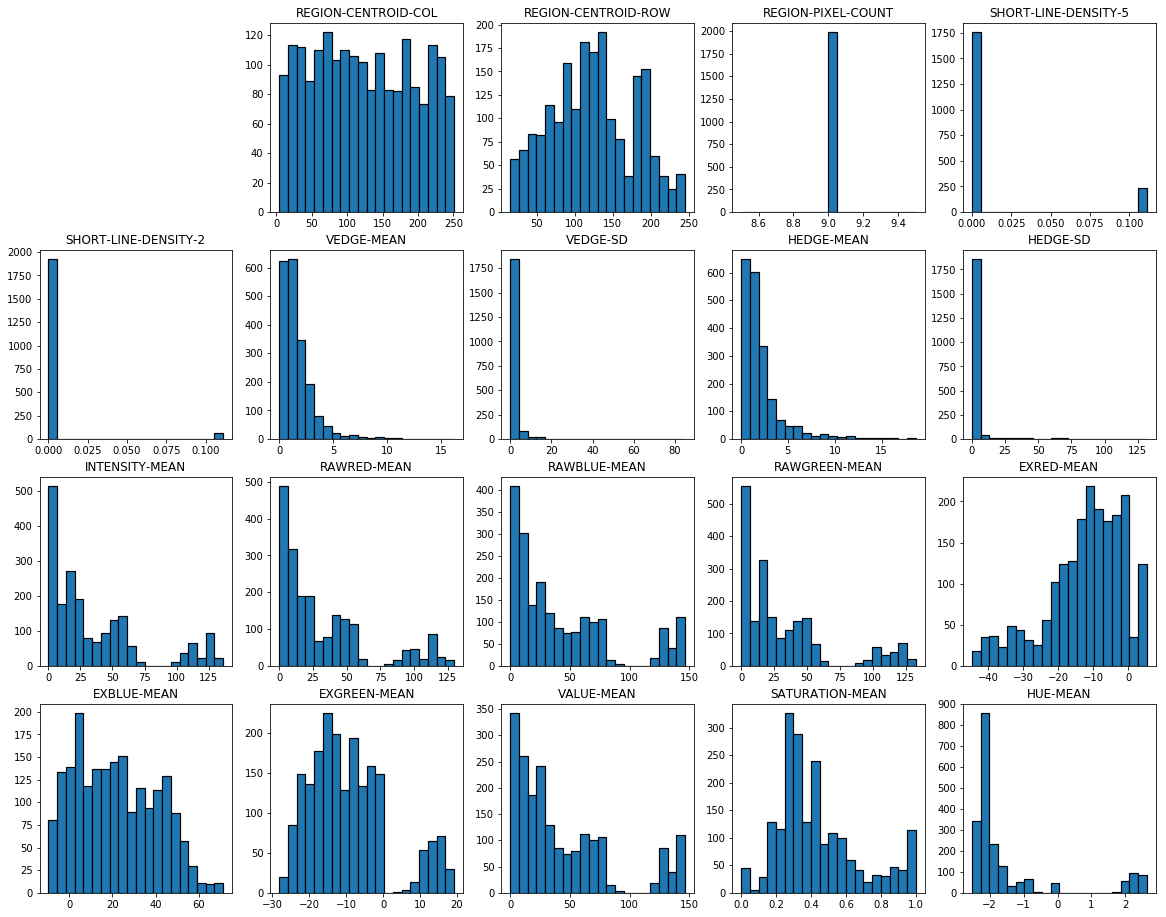

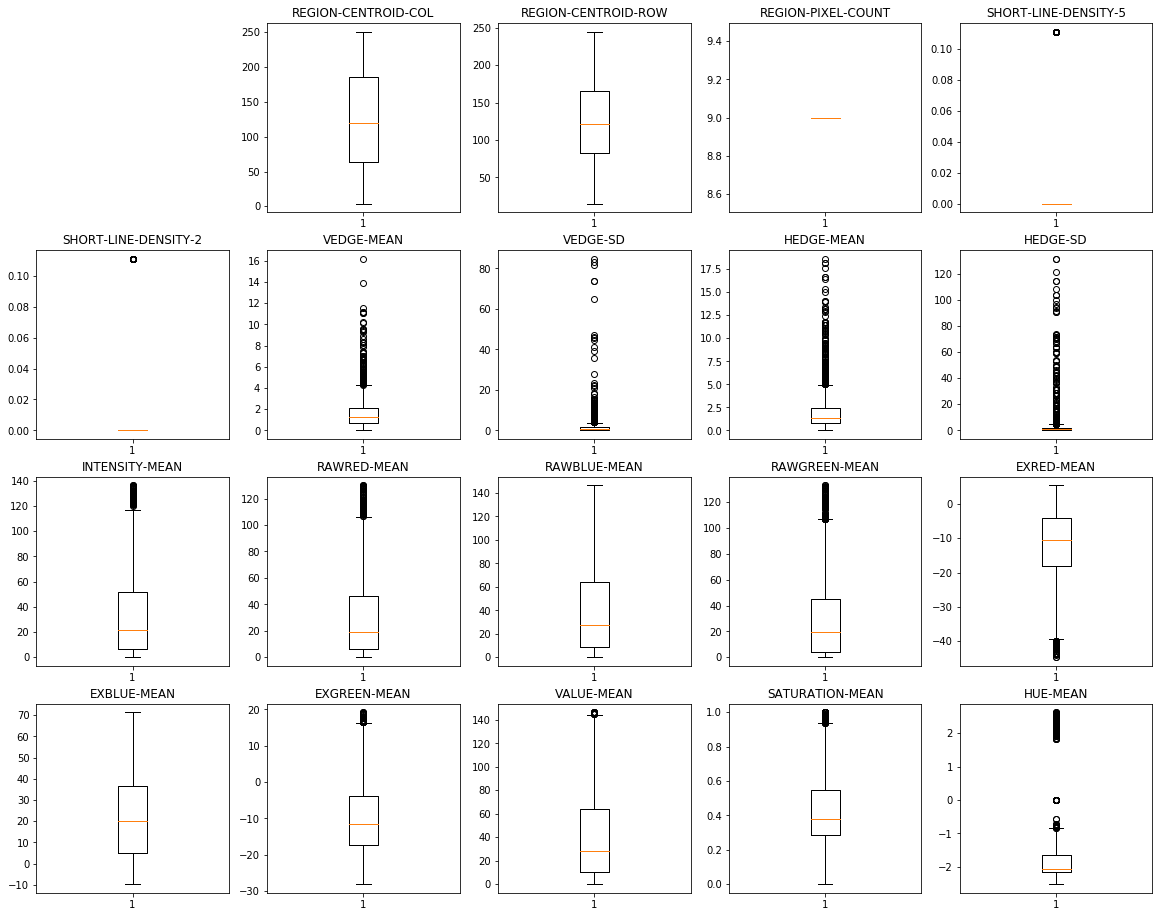

In [10]:
showGistogram(dfAllFilt)
showBox(dfAllFilt)

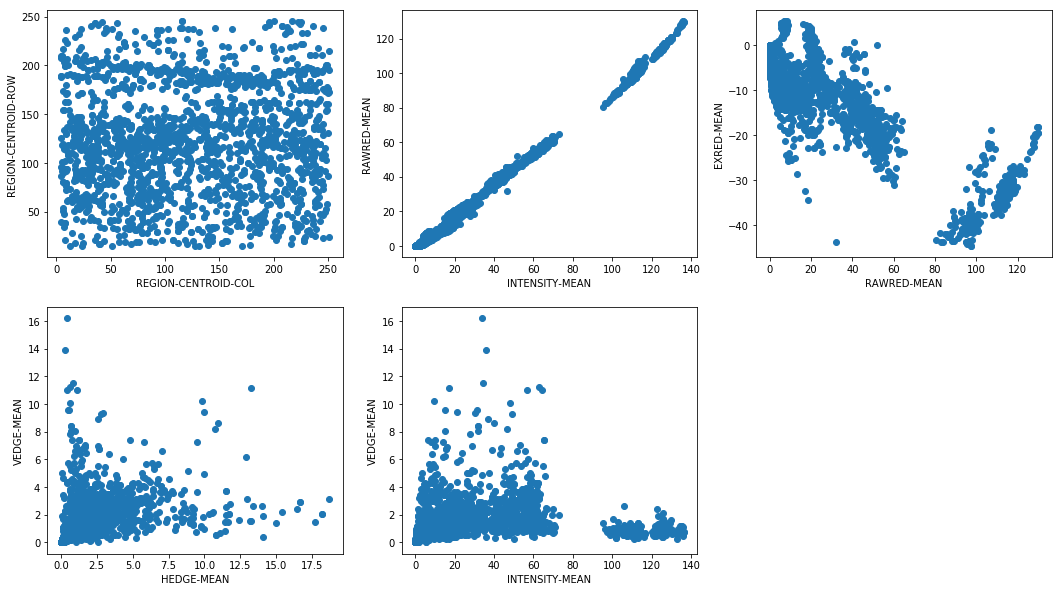

In [11]:
showScatters(dfAllFilt)

In [12]:
#standarting values
scaler = StandardScaler()
data_values_ = dfAllFilt.get_values()
data_values = data_values_[:,1:-1]
data_values = scaler.fit_transform(data_values)
data_values_[:,1:-1] = data_values
dfAllFiltNormalize = pd.DataFrame(data_values_)
dfAllFiltNormalize.columns = dfAllFilt.columns
dfAllFiltNormalize[dfAllFiltNormalize.columns[1:]] = dfAllFiltNormalize[dfAllFiltNormalize.columns[1:]].apply(pd.to_numeric)
#dfAllFiltNormalize

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


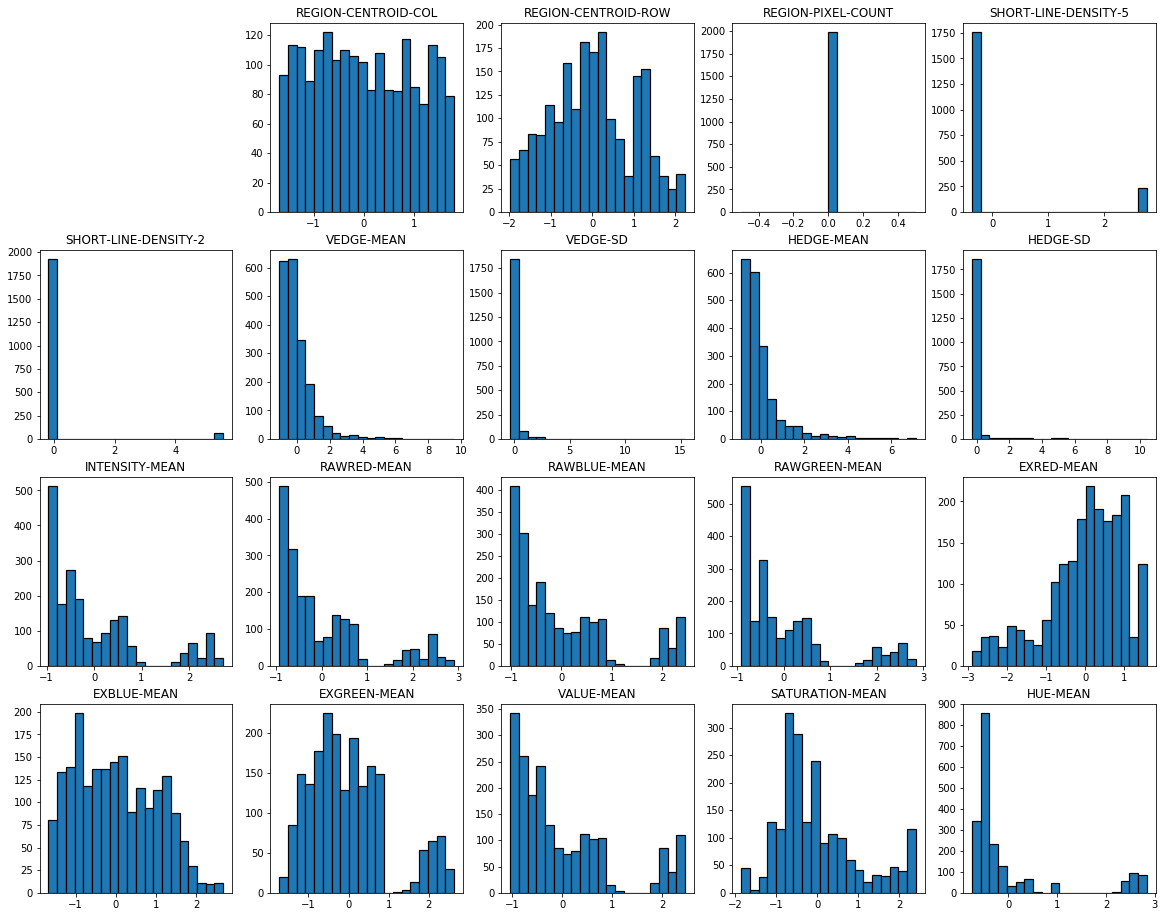

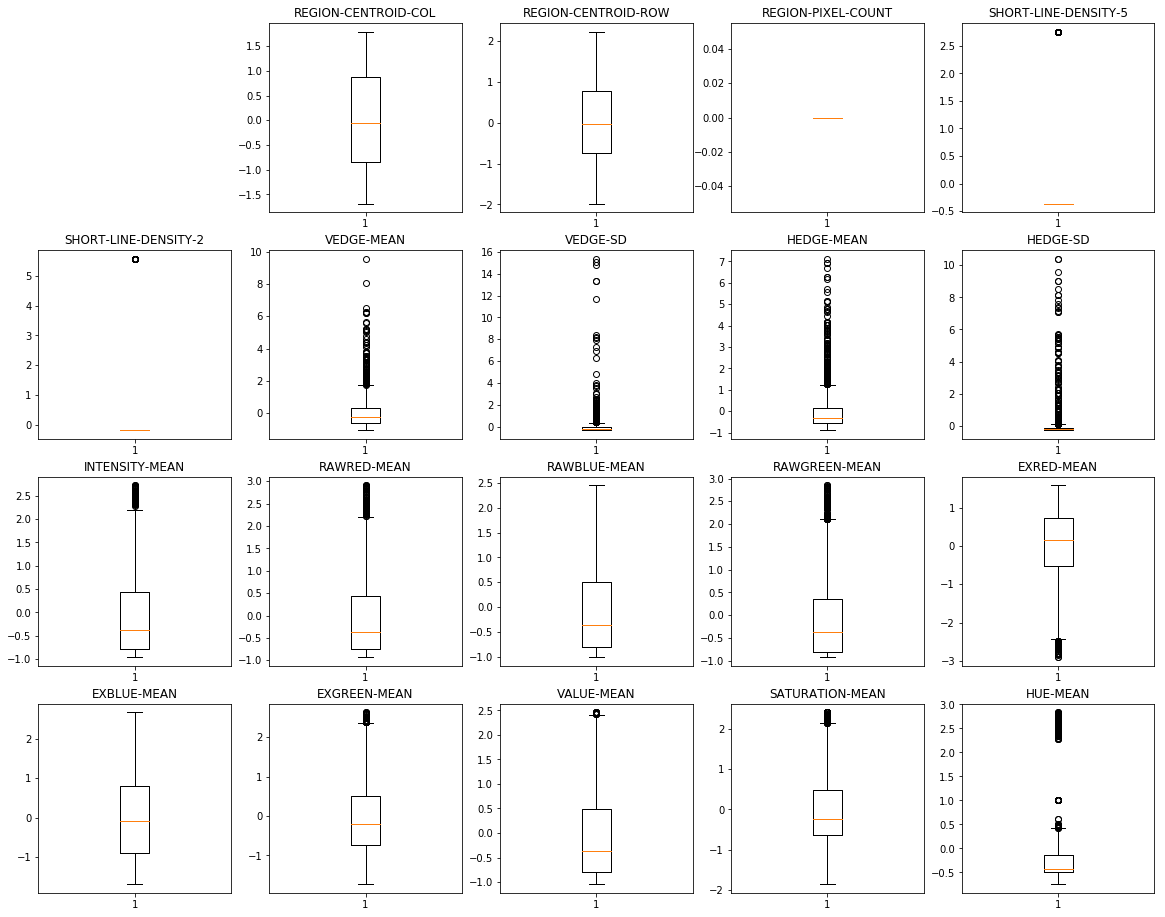

In [13]:
showGistogram(dfAllFiltNormalize)
showBox(dfAllFiltNormalize)

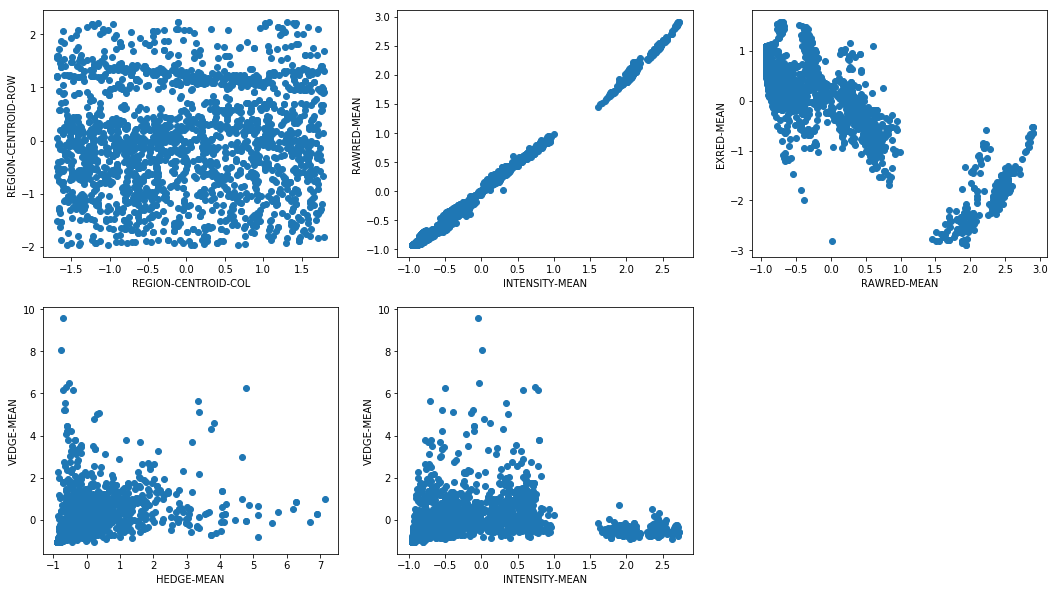

In [14]:
showScatters(dfAllFiltNormalize)

In [15]:
#удаление лишних столбцов #будет holdout 60/30/10 игнорируя условие задачи, удалили Type
dfAllReady = dfAllFiltNormalize.drop(dfAllFiltNormalize.columns[[3, 4, 5, 7, 9, -1]], axis=1)
#PCA
X = dfAllReady[['INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN','VALUE-MEAN']].get_values()
dfAllReady.drop(['INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN','VALUE-MEAN'], axis=1, inplace=True)
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(X)
dfAllReady['1'] = XPCAreduced[:,0]
dfAllReady['2'] = XPCAreduced[:,1]
#удаление как мне кажется бесполезных данных
#dfAllReady.drop(['REGION-CENTROID-ROW','REGION-CENTROID-COL'], axis=1, inplace=True)
dfAllReady.shape
#dfAllReady

(1988, 12)

In [224]:
#Net
def weight_init_xavier(m): 
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = np.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)
        m.bias.data.fill_(0.0)
        
def weight_init_sigma_small(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, 0.0001)
        m.bias.data.fill_(0.0)
        
def weight_init_sigma_big(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, 10.0)
        m.bias.data.fill_(0.0)
        
class Net(nn.Module):
    def __init__ (self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 7)
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        self.h1 = x
        x = self.fc2(x)
        x = F.sigmoid(x)
        self.h2 = x
        x = self.fc3(x)
        self.h3 = x
        #x = F.softmax(x)
        return x;
netFirstPointXavier = Net()
netFirstPointXavier.apply(weight_init_xavier)
netSmall = Net()
netSmall.apply(weight_init_sigma_small)
netBig = Net()
netBig.apply(weight_init_sigma_big)
#netFirstPointXavier.cuda()
#print(netSmall)
#net.fc1.weight.data

Net (
  (fc1): Linear (11 -> 20)
  (fc2): Linear (20 -> 10)
  (fc3): Linear (10 -> 7)
)

In [17]:
def smallQuery(vDataTest):
    x = Variable(torch.Tensor(vDataTest))
    y_pred = netFirstPointXavier(x)
    y_h = y_pred.data.cpu().numpy()
    np.set_printoptions(precision=3, suppress=True)
    return y_h;
def showResult(vDataTest, labels):
    y_h = smallQuery(vDataTest)
    errors = 0
    for i in range(y_h.shape[0]):
        var_max = -1
        ind_max = -1
        for j in range(y_h.shape[1]):
            if var_max < y_h[i][j]:
                var_max = y_h[i][j]
                ind_max = j
        if ind_max != labels[i]:
            errors += 1
    return errors

In [18]:
#функция деления данных
def split(data, train_koeph, valid_koeph, test_koeph):
    #отметим границы
    train_border = [0, round(len(data) * train_koeph)]
    valid_border = [round(len(data) * train_koeph), round(len(data) * (train_koeph + valid_koeph))]
    test_border = [round(len(data) * (train_koeph + valid_koeph)), len(data)]
    #делим
    train_data = (data[train_border[0]: train_border[1]])
    valid_data = (data[valid_border[0]: valid_border[1]])
    test_data = (data[test_border[0]: test_border[1]])
    return train_data, valid_data, test_data
#holdout 60/30/10
def holdout(df):
    train_koeph, valid_koeph, test_koeph = 0.6, 0.3, 0.1
    #перемешиваем
    data_ = df.get_values()
    np.random.shuffle(data_)
    return split(data_, train_koeph, valid_koeph, test_koeph)

In [19]:
train_data, valid_data, test_data = holdout(dfAllReady)
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
FEATURES_INDEX = np.arange(1,dfAllReady.shape[1])
LABEL_INDEX = 0

(1193, 12)
(596, 12)
(199, 12)


In [20]:
#проверить что хорошо помешалось
a = pd.DataFrame(train_data)
a.columns = dfAllReady.columns
print(a[a.CLASS == 'BRICKFACE'].shape[0])
print(a[a.CLASS == 'SKY'].shape[0])
print(a[a.CLASS == 'FOLIAGE'].shape[0])
print(a[a.CLASS == 'CEMENT'].shape[0])
print(a[a.CLASS == 'WINDOW'].shape[0])
print(a[a.CLASS == 'PATH'].shape[0])
print(a[a.CLASS == 'GRASS'].shape[0])

162
139
188
178
200
183
143


In [225]:
def oneHot(arr):
    out = np.zeros((arr.shape[0], 7))
    for i in range(arr.shape[0]):
        if(arr[i] == 'BRICKFACE'):
            out[i][0] = 1
        elif(arr[i] == 'SKY'):
            out[i][1] = 1
        elif(arr[i] == 'FOLIAGE'):
            out[i][2] = 1
        elif(arr[i] == 'CEMENT'):
            out[i][3] = 1
        elif(arr[i] == 'WINDOW'):
            out[i][4] = 1
        elif(arr[i] == 'PATH'):
            out[i][5] = 1
        elif(arr[i] == 'GRASS'):
            out[i][6] = 1
    return out

def toClass(arr):
    out = copy.copy(arr)
    for i in range(arr.shape[0]):
        if(arr[i] == 'BRICKFACE'):
            out[i] = 0
        elif(arr[i] == 'SKY'):
            out[i] = 1
        elif(arr[i] == 'FOLIAGE'):
            out[i] = 2
        elif(arr[i] == 'CEMENT'):
            out[i] = 3
        elif(arr[i] == 'WINDOW'):
            out[i] = 4
        elif(arr[i] == 'PATH'):
            out[i] = 5
        elif(arr[i] == 'GRASS'):
            out[i] = 6
    return out

def toNumClass(arr):
    if(arr == 'BRICKFACE'):
        return 0
    elif(arr == 'SKY'):
        return 1
    elif(arr == 'FOLIAGE'):
        return 2
    elif(arr == 'CEMENT'):
        return 3
    elif(arr == 'WINDOW'):
        return 4
    elif(arr == 'PATH'):
        return 5
    elif(arr == 'GRASS'):
        return 6

def learnGD(net__, train_data, valid_data, test_data, lrv, epochs, momentum, nesterov):
    for num in range(lrv.shape[0]):
        lr = lrv[num]
        net = copy.deepcopy(net__)
        x_var = 10000
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=lrv[num], momentum=momentum, nesterov=nesterov)
        loss_train, loss_valid, loss_test = [], [], []
        for iter in range(epochs):
            loss_train_acc = 0
            x = Variable(torch.Tensor(train_data[:,FEATURES_INDEX].tolist()))
            y = Variable(torch.Tensor(toClass(train_data[:,LABEL_INDEX]).tolist())).long()
            y_pred = net(x)
            loss = loss_fn(y_pred, y)
            loss_train_acc = loss.data[0]    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            x_valid = Variable(torch.Tensor(valid_data[:,FEATURES_INDEX].tolist()))
            y_valid = Variable(torch.Tensor(toClass(valid_data[:,LABEL_INDEX]).tolist())).long()
            x_test = Variable(torch.Tensor(test_data[:,FEATURES_INDEX].tolist()))
            y_test = Variable(torch.Tensor(toClass(test_data[:,LABEL_INDEX]).tolist())).long()
            y_valid_pred = net(x_valid)
            y_test_pred = net(x_test)

            loss_train.append(loss_train_acc)
            loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
            loss_test.append(loss_fn(y_test_pred, y_test).data[0])

            #if loss_valid[-1] < x_var:
            #    x_var = loss_valid[-1]
            #elif loss_valid[-1] - x_var > 0.06:
            #    break

            if((iter + 1) % 1000 == 0):
                print(str(iter + 1) + " done")
        
        print("all done")
        plt.plot(loss_train, label = "train loss")
        plt.plot(loss_valid, label = "valid loss")
        plt.plot(loss_test, label = "test loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print(loss_train[-1], loss_valid[-1], loss_test[-1])
        plt.savefig('SGD/learn_loss  ' + str(lr) + ' ' + str(momentum) + ' ' + str(nesterov) + '  .png', bbox_inches='tight')
        plt.show()

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
all done
0.006345025263726711 0.09855140745639801 0.1584932953119278


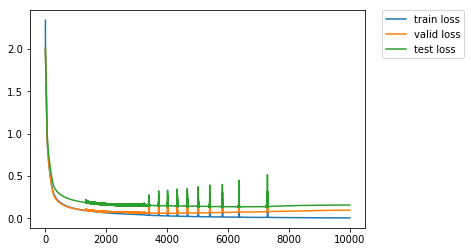

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
all done
0.11232628673315048 0.11195403337478638 0.21050813794136047


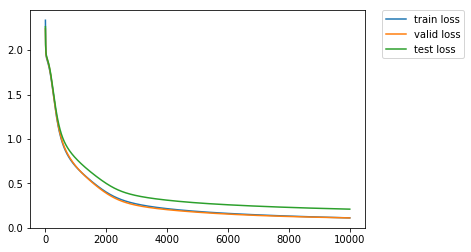

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
all done
0.6886911988258362 0.6938436627388 0.7815152406692505


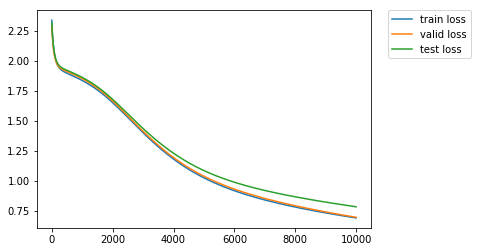

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
all done
1.8336987495422363 1.8491584062576294 1.8598120212554932


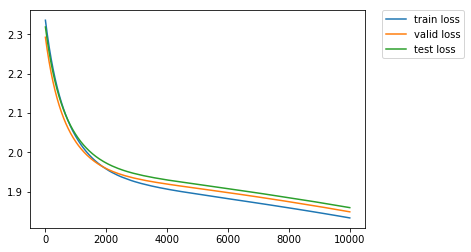

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
all done
2.0403127670288086 2.0269739627838135 2.045198678970337


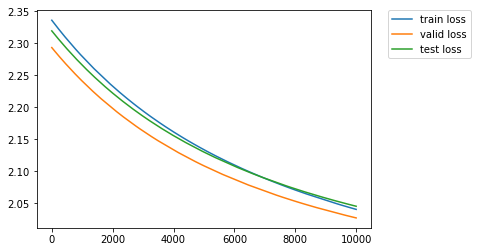

In [69]:
lrv = np.array([1.0, 0.1, 0.01, 0.001, 0.0001])
learnGD(train_data, valid_data, test_data, lrv, 10000, 0.00000, False)

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.01790490746498108 0.08855953067541122 0.26713743805885315


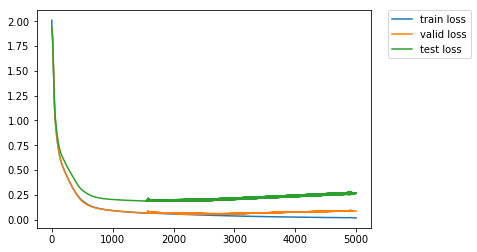

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.01801404356956482 0.08830149471759796 0.2634007930755615


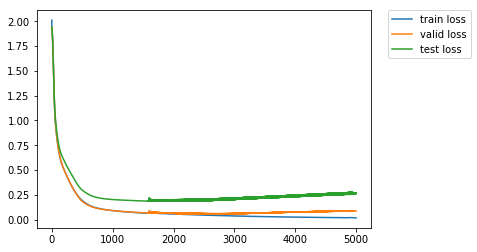

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.0095457648858428 0.0965653583407402 0.3203602433204651


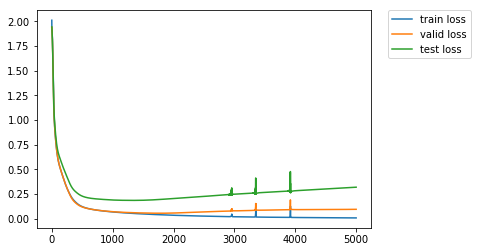

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.010660001076757908 0.09407678991556168 0.2935084402561188


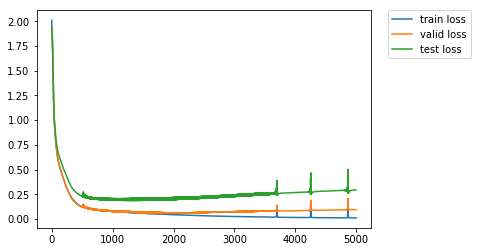

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.004143754485994577 0.08281005173921585 0.32306191325187683


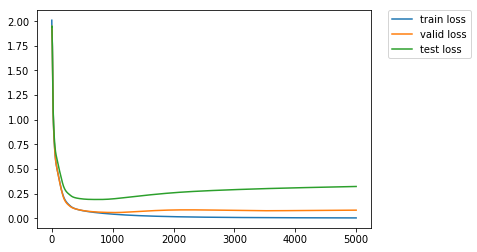

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.004531986080110073 0.10239319503307343 0.3057657778263092


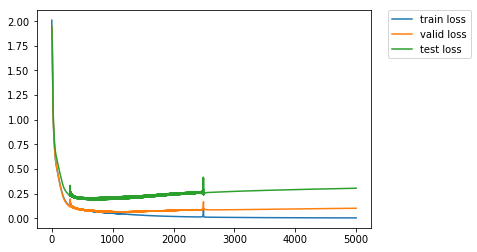

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.0007498167105950415 0.12446428090333939 0.4536314010620117


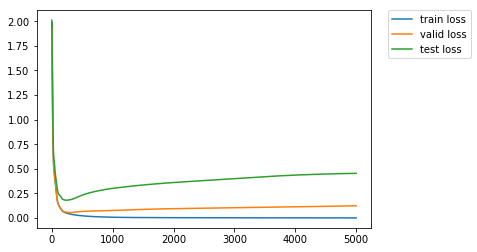

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.0006185659440234303 0.14528049528598785 0.364808589220047


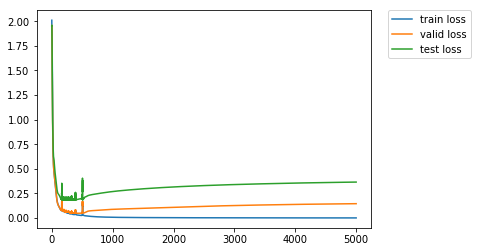

In [80]:
lrv = np.array([1.0])
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.0000001, False)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.0000001, True)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.3, False)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.3, True)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.6, False)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.6, True)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.9, False)
learnGD(train_data, valid_data, test_data, lrv, 5000, 0.9, True)

In [158]:
def get_lr(state, lr):
    tmp = state['sum']
    tmp = lr*torch.rsqrt(tmp.add_(1e-10))
    return tmp

def learnAdagrad(train_data, valid_data, test_data, lrv, epochs):
    for num in range(lrv.shape[0]):
        net = copy.deepcopy(netFirstPointXavier)
        lr = lrv[num]
        x_var = 10000
        min_acc = 1000
        max_acc = -1000
        mean_acc = 0
        lr_l1 = []
        lr_l2 = []
        lr_l3 = []
        lr_l4 = []

        lr_mean = []
        lr_min = []
        lr_max = []
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adagrad(net.parameters(), lr=lrv[num])
        state = optimizer.state
        loss_train, loss_valid, loss_test = [], [], []
        for iter in range(epochs):
            loss_train_acc = 0
            x = Variable(torch.Tensor(train_data[:,FEATURES_INDEX].tolist()))
            y = Variable(torch.Tensor(toClass(train_data[:,LABEL_INDEX]).tolist())).long()
            y_pred = net(x)   
            loss = loss_fn(y_pred, y)
            loss_train_acc = loss.data[0]    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            x_valid = Variable(torch.Tensor(valid_data[:,FEATURES_INDEX].tolist()))
            y_valid = Variable(torch.Tensor(toClass(valid_data[:,LABEL_INDEX]).tolist())).long()
            x_test = Variable(torch.Tensor(test_data[:,FEATURES_INDEX].tolist()))
            y_test = Variable(torch.Tensor(toClass(test_data[:,LABEL_INDEX]).tolist())).long()
            y_valid_pred = net(x_valid)
            y_test_pred = net(x_test)

            loss_train.append(loss_train_acc)
            loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
            loss_test.append(loss_fn(y_test_pred, y_test).data[0])

            #if loss_valid[-1] < x_var:
            #    x_var = loss_valid[-1]
            #elif loss_valid[-1] - x_var > 0.06:
            #    break

            if((iter + 1) % 1000 == 0):
                print(str(iter + 1) + " done")
            min_acc = 1000
            max_acc = -1000
            mean_acc = 0    
            state_values = list(state.values())
            for k in range(len(state_values)):
                g_matrix = get_lr(state_values[k], lr)
                mean_acc += float(torch.mean(g_matrix))
                max_acc = max(max_acc, float(torch.max(g_matrix)))
                min_acc = min(min_acc, float(torch.min(g_matrix)))
            lr_max.append(max_acc)
            lr_mean.append(mean_acc/len(state_values))
            lr_min.append(min_acc)
            
            g_matrix = get_lr(state_values[0], lr)
            lr_l1.append(float(g_matrix[19, 5]))

            g_matrix = get_lr(state_values[2], lr)
            lr_l2.append(float(g_matrix[1, 7]))

            g_matrix = get_lr(state_values[4], lr)
            lr_l3.append(float(g_matrix[2, 3]))
        
        print("all done")
        plt.plot(loss_train, label = "train loss")
        plt.plot(loss_valid, label = "valid loss")
        #plt.plot(loss_test, label = "test loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print(loss_train[-1], loss_valid[-1], loss_test[-1])
        plt.savefig('adagrad/learn_loss.png', bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(lr_l1, label='lr l1 w19,5')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(lr_l2, label='lr l2 w1,4')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(lr_l3, label='lr l3 w2,3')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(lr_max, label='max')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(lr_mean, label='mean')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(lr_min, label='min')
        plt.legend()

        plt.savefig('adagrad/lrs.png', bbox_inches='tight')
        plt.show()

1000 done
all done
0.039453763514757156 0.06054740771651268 0.18173176050186157


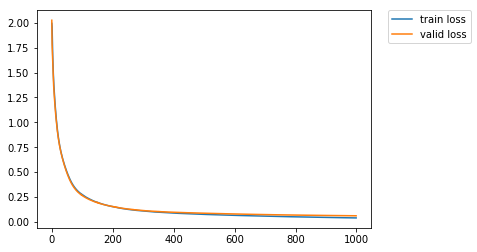

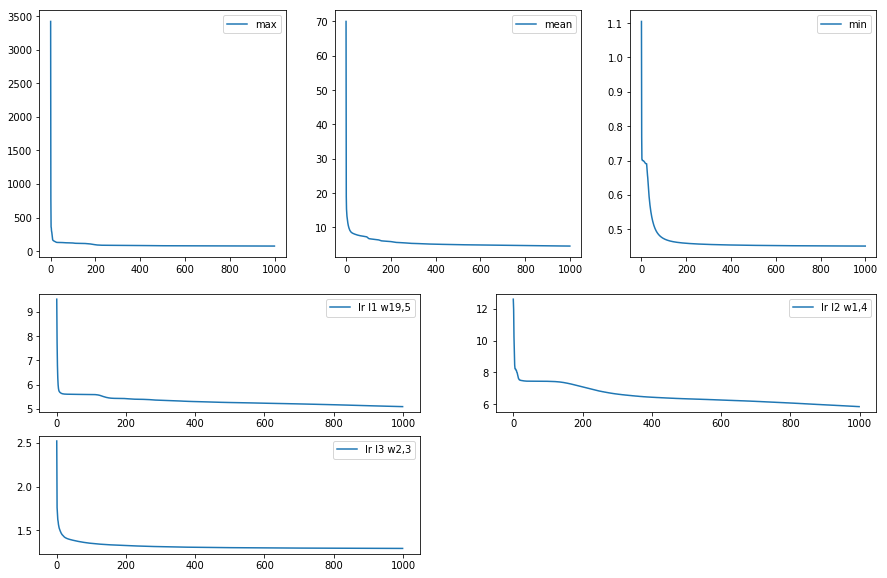

In [159]:
lrv = np.array([0.1])
learnAdagrad(train_data, valid_data, test_data, lrv, 1000)

In [116]:
def get_lr(state, lr):
    square_avg = state['square_avg']
    acc_delta = state['acc_delta']
    std = square_avg.add(1e-7).sqrt_()
    delta = lr * acc_delta.add(1e-7).sqrt_().div_(std)
    return delta

def learnAdadelta(train_data, valid_data, test_data, lrv, epochs, rho_):
    for num in range(lrv.shape[0]):
        net = copy.deepcopy(netFirstPointXavier)
        lr = lrv[num]
        x_var = 10000
        min_acc = 1000
        max_acc = -1000
        mean_acc = 0
        lr_l1 = []
        lr_l2 = []
        lr_l3 = []
        lr_l4 = []

        lr_mean = []
        lr_min = []
        lr_max = []
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adadelta(net.parameters(), lr=lrv[num], rho=rho_)
        state = optimizer.state
        loss_train, loss_valid, loss_test = [], [], []
        for iter in range(epochs):
            loss_train_acc = 0
            x = Variable(torch.Tensor(train_data[:,FEATURES_INDEX].tolist()))
            y = Variable(torch.Tensor(toClass(train_data[:,LABEL_INDEX]).tolist())).long()
            y_pred = net(x)   
            loss = loss_fn(y_pred, y)
            loss_train_acc = loss.data[0]    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            x_valid = Variable(torch.Tensor(valid_data[:,FEATURES_INDEX].tolist()))
            y_valid = Variable(torch.Tensor(toClass(valid_data[:,LABEL_INDEX]).tolist())).long()
            x_test = Variable(torch.Tensor(test_data[:,FEATURES_INDEX].tolist()))
            y_test = Variable(torch.Tensor(toClass(test_data[:,LABEL_INDEX]).tolist())).long()
            y_valid_pred = net(x_valid)
            y_test_pred = net(x_test)

            loss_train.append(loss_train_acc)
            loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
            loss_test.append(loss_fn(y_test_pred, y_test).data[0])

            #if loss_valid[-1] < x_var:
            #    x_var = loss_valid[-1]
            #elif loss_valid[-1] - x_var > 0.06:
            #    break

            if((iter + 1) % 1000 == 0):
                print(str(iter + 1) + " done")
            min_acc = 1000
            max_acc = -1000
            mean_acc = 0    
            state_values = list(state.values())
            for k in range(len(state_values)):
                g_matrix = get_lr(state_values[k], lr)
                mean_acc += float(torch.mean(g_matrix))
                max_acc = max(max_acc, float(torch.max(g_matrix)))
                min_acc = min(min_acc, float(torch.min(g_matrix)))
            lr_max.append(max_acc)
            lr_mean.append(mean_acc/len(state_values))
            lr_min.append(min_acc)
            
            g_matrix = get_lr(state_values[0], lr)
            lr_l1.append(float(g_matrix[19, 5]))

            g_matrix = get_lr(state_values[2], lr)
            lr_l2.append(float(g_matrix[1, 4]))

            g_matrix = get_lr(state_values[4], lr)
            lr_l3.append(float(g_matrix[2, 3]))
        
        print("all done")
        plt.plot(loss_train, label = "train loss")
        plt.plot(loss_valid, label = "valid loss")
        plt.plot(loss_test, label = "test loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print(loss_train[-1], loss_valid[-1], loss_test[-1])
        plt.title("koeph p = " + str(rho_))
        plt.savefig('adadelta/learn_loss ' + str(rho_) + '.png', bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(lr_l1, label='lr l1 w19,5')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(lr_l2, label='lr l2 w1,4')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(lr_l3, label='lr l3 w2,3')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(lr_max, label='max')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(lr_mean, label='mean')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(lr_min, label='min')
        plt.legend()
        
        plt.savefig('adadelta/lrs' + str(rho_) + '.png', bbox_inches='tight')
        plt.show()
        return lr_l1, lr_l2, lr_l3, lr_max, lr_mean, lr_min

1000 done
2000 done
3000 done
all done
0.03727313131093979 0.06089332699775696 0.17559576034545898


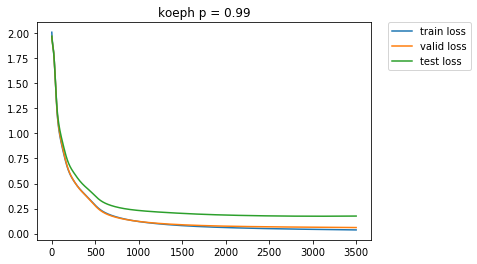

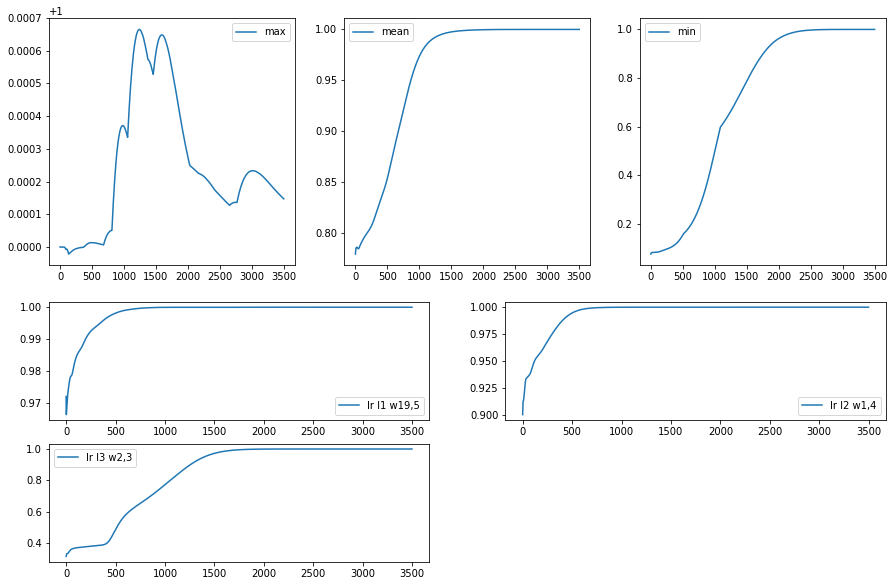

1000 done
2000 done
3000 done
all done
0.03289168328046799 0.0874343290925026 0.21144311130046844


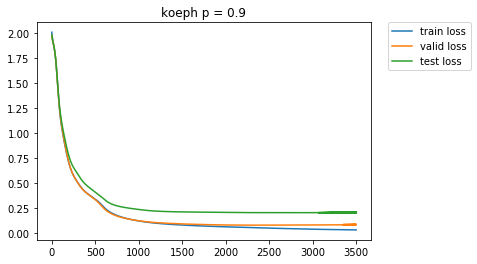

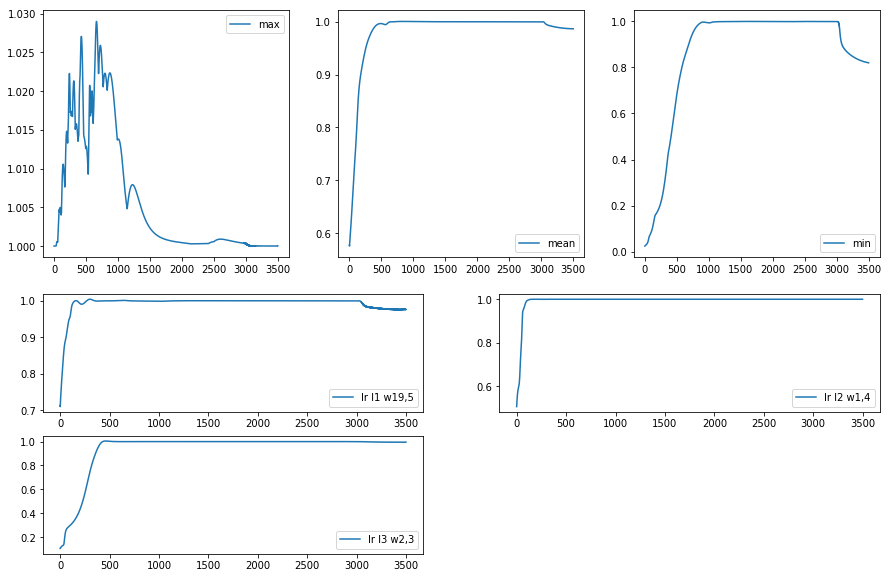

1000 done
2000 done
3000 done
all done
0.034317728132009506 0.06076982244849205 0.2026461362838745


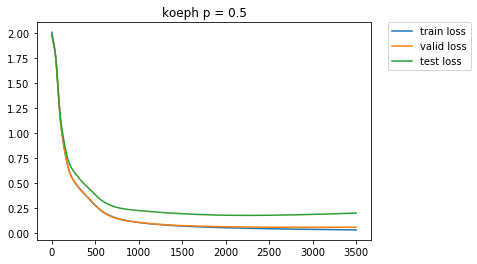

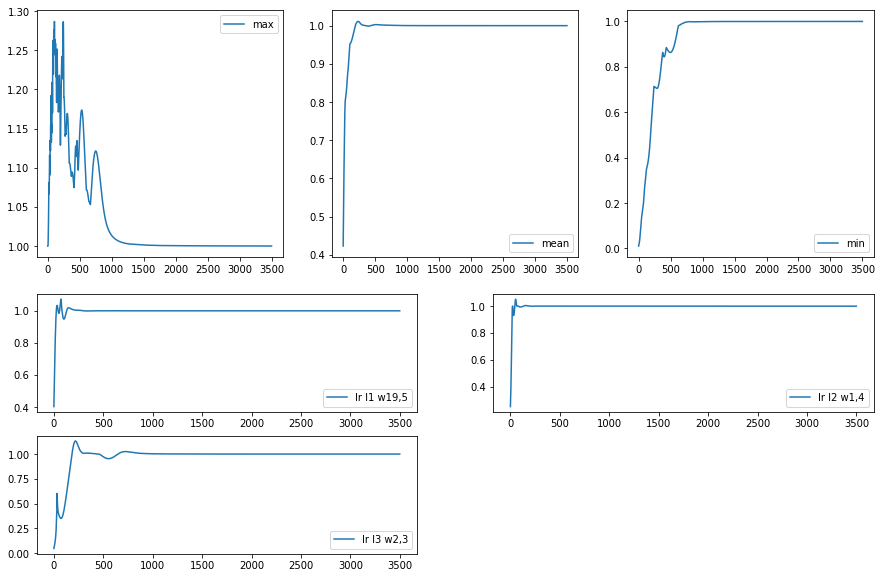

1000 done
2000 done
3000 done
all done
0.03913120552897453 0.06958936899900436 0.2072724550962448


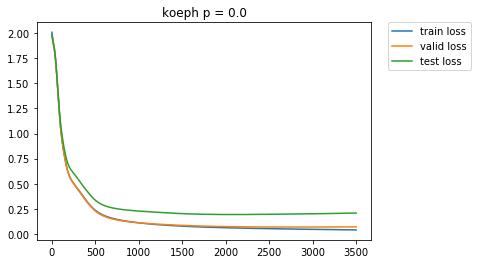

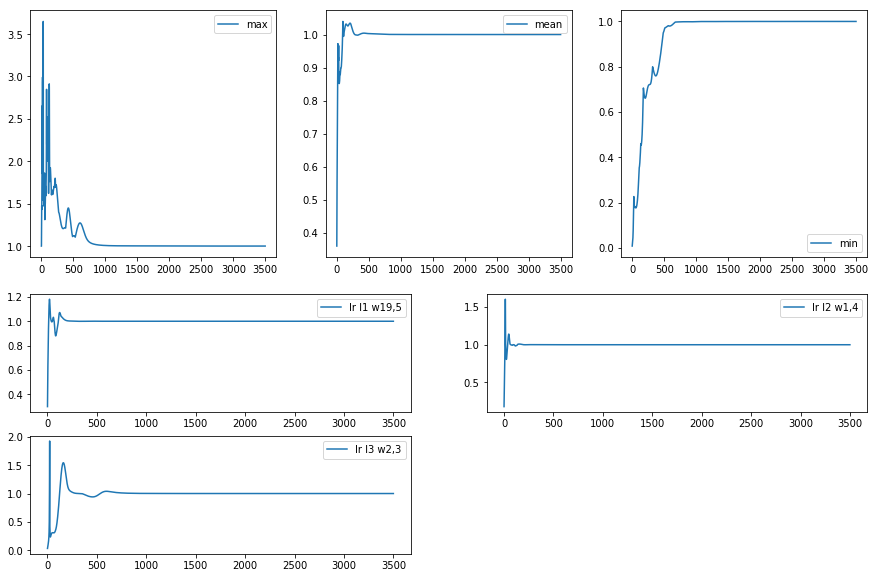

In [118]:
lrv = np.array([1.0])
a1, a2, a3, a4, a5, a6 = [], [], [], [], [], []
a1, a2, a3, a4, a5, a6 = learnAdadelta(train_data, valid_data, test_data, lrv, 3500, 0.99)
lrv = np.array([1.0])
b1, b2, b3, b4, b5, b6 = [], [], [], [], [], []
b1, b2, b3, b4, b5, b6 = learnAdadelta(train_data, valid_data, test_data, lrv, 3500, 0.9)
lrv = np.array([1.0])
c1, c2, c3, c4, c5, c6 = [], [], [], [], [], []
c1, c2, c3, c4, c5, c6 = learnAdadelta(train_data, valid_data, test_data, lrv, 3500, 0.5)
lrv = np.array([1.0])
d1, d2, d3, d4, d5, d6 = [], [], [], [], [], []
d1, d2, d3, d4, d5, d6 = learnAdadelta(train_data, valid_data, test_data, lrv, 3500, 0.0)

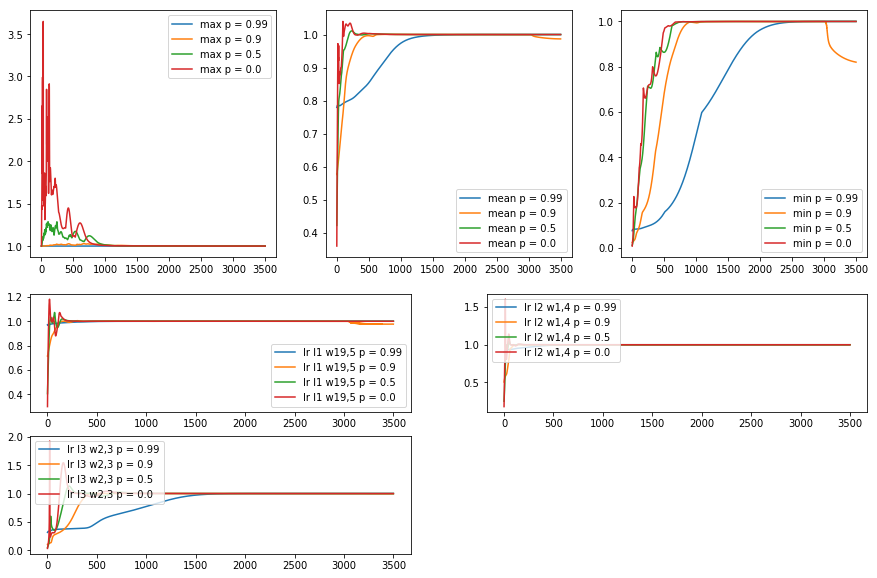

In [119]:
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(a1, label='lr l1 w19,5 p = 0.99')
        plt.plot(b1, label='lr l1 w19,5 p = 0.9')
        plt.plot(c1, label='lr l1 w19,5 p = 0.5')
        plt.plot(d1, label='lr l1 w19,5 p = 0.0')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(a2, label='lr l2 w1,4 p = 0.99')
        plt.plot(b2, label='lr l2 w1,4 p = 0.9')
        plt.plot(c2, label='lr l2 w1,4 p = 0.5')
        plt.plot(d2, label='lr l2 w1,4 p = 0.0')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(a3, label='lr l3 w2,3 p = 0.99')
        plt.plot(b3, label='lr l3 w2,3 p = 0.9')
        plt.plot(c3, label='lr l3 w2,3 p = 0.5')
        plt.plot(d3, label='lr l3 w2,3 p = 0.0')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(a4, label='max p = 0.99')
        plt.plot(b4, label='max p = 0.9')
        plt.plot(c4, label='max p = 0.5')
        plt.plot(d4, label='max p = 0.0')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(a5, label='mean p = 0.99')
        plt.plot(b5, label='mean p = 0.9')
        plt.plot(c5, label='mean p = 0.5')
        plt.plot(d5, label='mean p = 0.0')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(a6, label='min p = 0.99')
        plt.plot(b6, label='min p = 0.9')
        plt.plot(c6, label='min p = 0.5')
        plt.plot(d6, label='min p = 0.0')
        plt.legend()
        
        plt.savefig('adadelta/lrs.png', bbox_inches='tight')
        plt.show()

In [121]:
def get_lr(state, lr):
    tmp = state['square_avg']
    tmp = lr*tmp.sqrt().add_(1e-08)
    return tmp

def learnRMSprop(train_data, valid_data, test_data, lrv, epochs, rho):
    for num in range(lrv.shape[0]):
        net = copy.deepcopy(netFirstPointXavier)
        lr = lrv[num]
        x_var = 10000
        min_acc = 1000
        max_acc = -1000
        mean_acc = 0
        lr_l1 = []
        lr_l2 = []
        lr_l3 = []
        lr_l4 = []

        lr_mean = []
        lr_min = []
        lr_max = []
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=rho)
        state = optimizer.state
        loss_train, loss_valid, loss_test = [], [], []
        for iter in range(epochs):
            loss_train_acc = 0
            x = Variable(torch.Tensor(train_data[:,FEATURES_INDEX].tolist()))
            y = Variable(torch.Tensor(toClass(train_data[:,LABEL_INDEX]).tolist())).long()
            y_pred = net(x)   
            loss = loss_fn(y_pred, y)
            loss_train_acc = loss.data[0]    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            x_valid = Variable(torch.Tensor(valid_data[:,FEATURES_INDEX].tolist()))
            y_valid = Variable(torch.Tensor(toClass(valid_data[:,LABEL_INDEX]).tolist())).long()
            x_test = Variable(torch.Tensor(test_data[:,FEATURES_INDEX].tolist()))
            y_test = Variable(torch.Tensor(toClass(test_data[:,LABEL_INDEX]).tolist())).long()
            y_valid_pred = net(x_valid)
            y_test_pred = net(x_test)

            loss_train.append(loss_train_acc)
            loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
            loss_test.append(loss_fn(y_test_pred, y_test).data[0])

            #if loss_valid[-1] < x_var:
            #    x_var = loss_valid[-1]
            #elif loss_valid[-1] - x_var > 0.06:
            #    break

            if((iter + 1) % 1000 == 0):
                print(str(iter + 1) + " done")
            min_acc = 1000
            max_acc = -1000
            mean_acc = 0    
            state_values = list(state.values())
            for k in range(len(state_values)):
                g_matrix = get_lr(state_values[k], lr)
                mean_acc += float(torch.mean(g_matrix))
                max_acc = max(max_acc, float(torch.max(g_matrix)))
                min_acc = min(min_acc, float(torch.min(g_matrix)))
            lr_max.append(max_acc)
            lr_mean.append(mean_acc/len(state_values))
            lr_min.append(min_acc)
            
            g_matrix = get_lr(state_values[0], lr)
            lr_l1.append(float(g_matrix[19, 5]))

            g_matrix = get_lr(state_values[2], lr)
            lr_l2.append(float(g_matrix[1, 4]))

            g_matrix = get_lr(state_values[4], lr)
            lr_l3.append(float(g_matrix[2, 3]))
        
        print("all done")
        plt.plot(loss_train, label = "train loss")
        plt.plot(loss_valid, label = "valid loss")
        plt.plot(loss_test, label = "test loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print(loss_train[-1], loss_valid[-1], loss_test[-1])
        plt.title("adagrad p = " + str(rho))
        plt.savefig('rmsprop/learn_loss ' + str(rho) + '.png', bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(lr_l1, label='lr l1 w19,5')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(lr_l2, label='lr l2 w1,4')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(lr_l3, label='lr l3 w2,3')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(lr_max, label='max')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(lr_mean, label='mean')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(lr_min, label='min')
        plt.legend()
        
        plt.savefig('rmsprop/lrs' + str(rho) + '.png', bbox_inches='tight')
        plt.show()
        return lr_l1, lr_l2, lr_l3, lr_max, lr_mean, lr_min

1000 done
2000 done
3000 done
all done
1.657501220703125 1.8323960304260254 1.8490617275238037


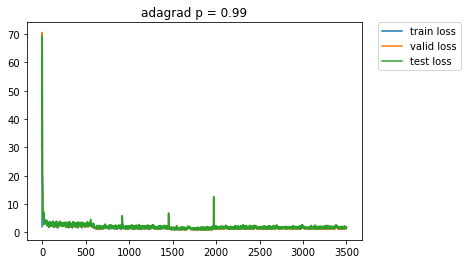

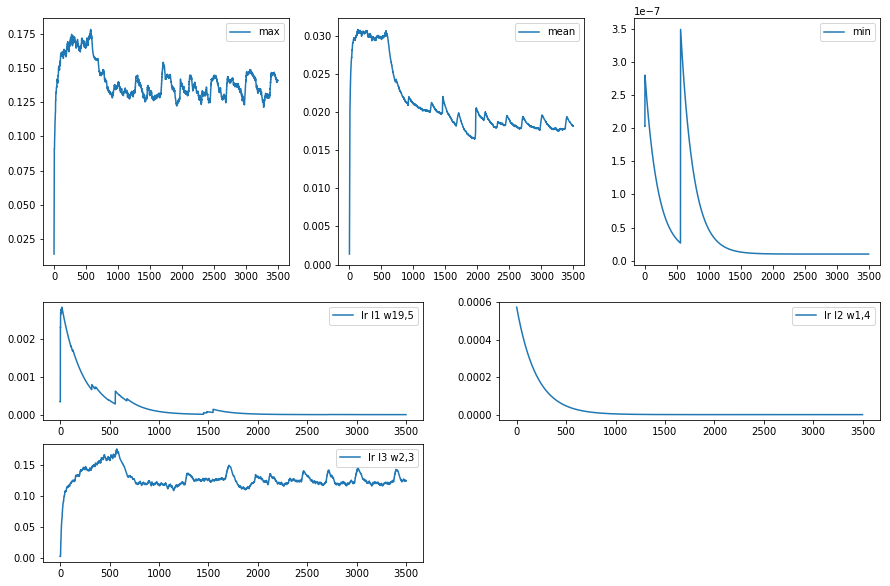

1000 done
2000 done
3000 done
all done
0.39985138177871704 0.40584737062454224 0.8900410532951355


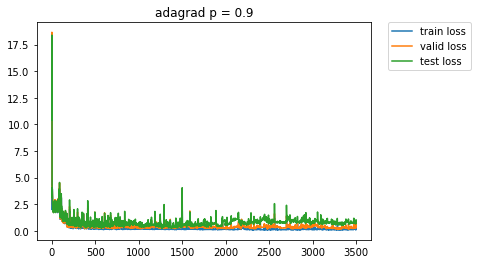

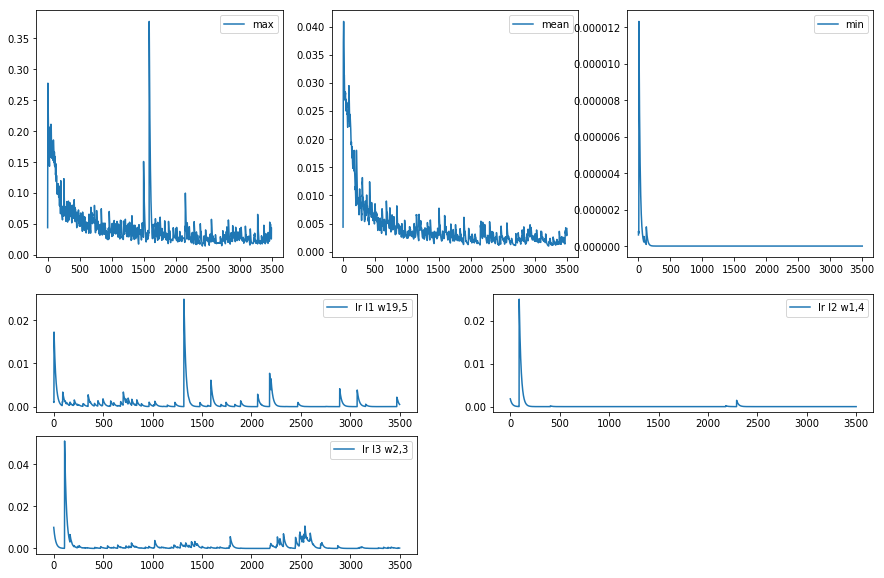

1000 done
2000 done
3000 done
all done
0.050463851541280746 0.719944953918457 0.9884217381477356


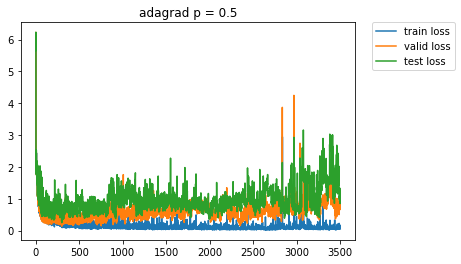

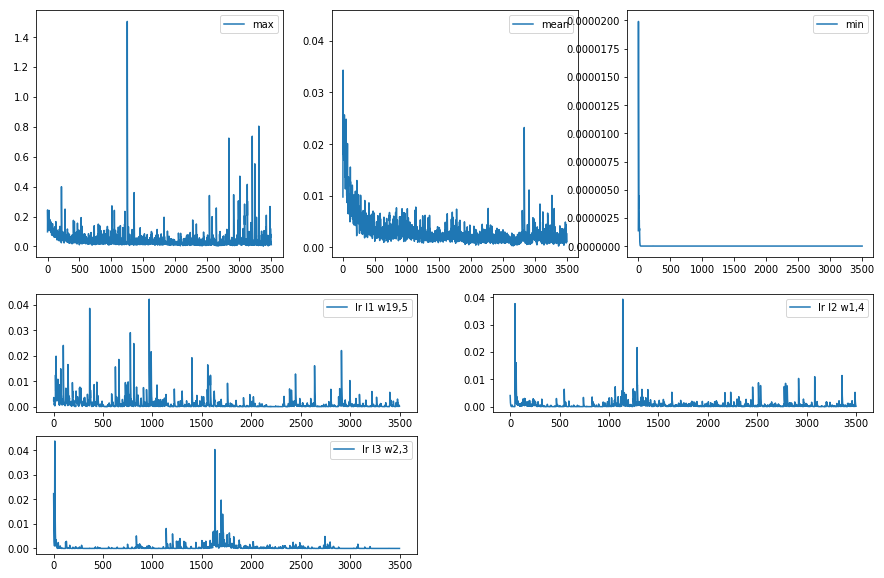

1000 done
2000 done
3000 done
all done
0.294607937335968 2.615718364715576 4.493834495544434


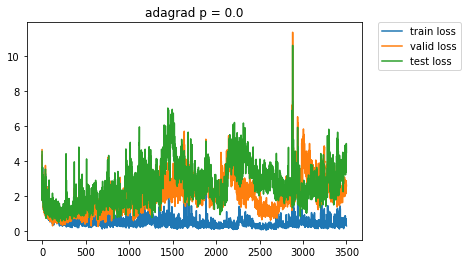

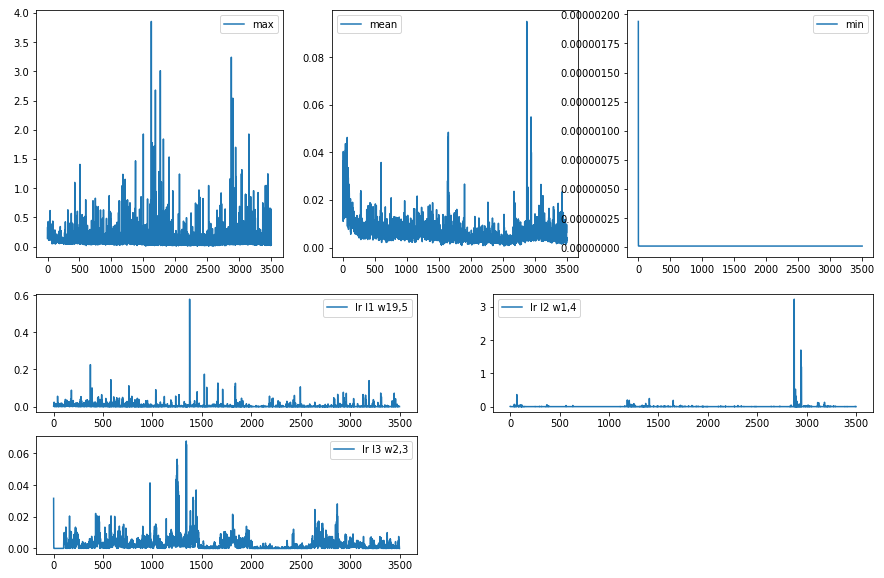

In [123]:
lrv = np.array([1.0])
a1, a2, a3, a4, a5, a6 = [], [], [], [], [], []
a1, a2, a3, a4, a5, a6 = learnRMSprop(train_data, valid_data, test_data, lrv, 3500, 0.99)
lrv = np.array([1.0])
b1, b2, b3, b4, b5, b6 = [], [], [], [], [], []
b1, b2, b3, b4, b5, b6 = learnRMSprop(train_data, valid_data, test_data, lrv, 3500, 0.9)
lrv = np.array([1.0])
c1, c2, c3, c4, c5, c6 = [], [], [], [], [], []
c1, c2, c3, c4, c5, c6 = learnRMSprop(train_data, valid_data, test_data, lrv, 3500, 0.5)
lrv = np.array([1.0])
d1, d2, d3, d4, d5, d6 = [], [], [], [], [], []
d1, d2, d3, d4, d5, d6 = learnRMSprop(train_data, valid_data, test_data, lrv, 3500, 0.0)

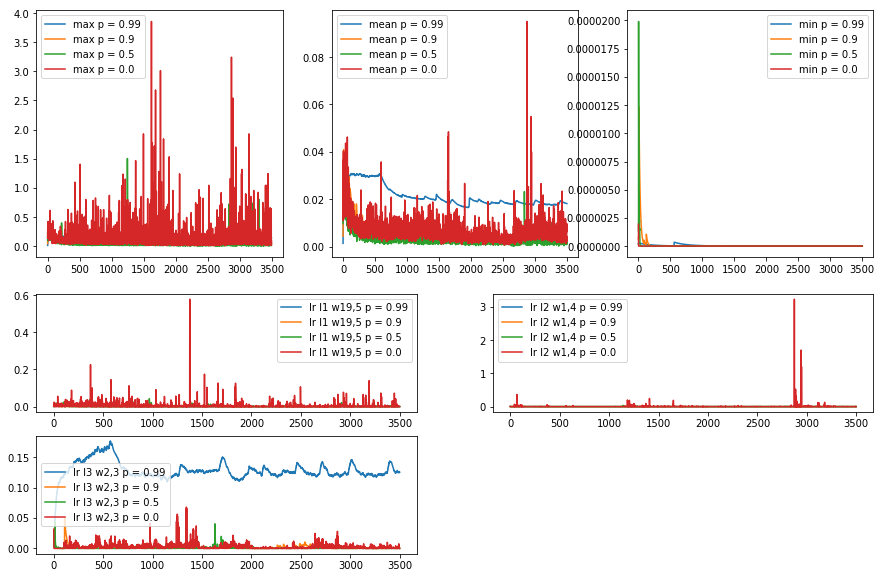

In [124]:
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(a1, label='lr l1 w19,5 p = 0.99')
        plt.plot(b1, label='lr l1 w19,5 p = 0.9')
        plt.plot(c1, label='lr l1 w19,5 p = 0.5')
        plt.plot(d1, label='lr l1 w19,5 p = 0.0')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(a2, label='lr l2 w1,4 p = 0.99')
        plt.plot(b2, label='lr l2 w1,4 p = 0.9')
        plt.plot(c2, label='lr l2 w1,4 p = 0.5')
        plt.plot(d2, label='lr l2 w1,4 p = 0.0')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(a3, label='lr l3 w2,3 p = 0.99')
        plt.plot(b3, label='lr l3 w2,3 p = 0.9')
        plt.plot(c3, label='lr l3 w2,3 p = 0.5')
        plt.plot(d3, label='lr l3 w2,3 p = 0.0')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(a4, label='max p = 0.99')
        plt.plot(b4, label='max p = 0.9')
        plt.plot(c4, label='max p = 0.5')
        plt.plot(d4, label='max p = 0.0')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(a5, label='mean p = 0.99')
        plt.plot(b5, label='mean p = 0.9')
        plt.plot(c5, label='mean p = 0.5')
        plt.plot(d5, label='mean p = 0.0')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(a6, label='min p = 0.99')
        plt.plot(b6, label='min p = 0.9')
        plt.plot(c6, label='min p = 0.5')
        plt.plot(d6, label='min p = 0.0')
        plt.legend()
        
        plt.savefig('rmsprop/lrs.png', bbox_inches='tight')
        plt.show()

In [125]:
def get_delta(state_value):
    return state_value['step_size']

def learnRprop(train_data, valid_data, test_data, lrv, epochs):
    for num in range(lrv.shape[0]):
        net = copy.deepcopy(netFirstPointXavier)
        lr = lrv[num]
        x_var = 10000
        min_acc = 1000
        max_acc = -1000
        mean_acc = 0
        lr_l1 = []
        lr_l2 = []
        lr_l3 = []
        lr_l4 = []

        lr_mean = []
        lr_min = []
        lr_max = []
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Rprop(net.parameters(), lr=lr)
        state = optimizer.state
        loss_train, loss_valid, loss_test = [], [], []
        for iter in range(epochs):
            loss_train_acc = 0
            x = Variable(torch.Tensor(train_data[:,FEATURES_INDEX].tolist()))
            y = Variable(torch.Tensor(toClass(train_data[:,LABEL_INDEX]).tolist())).long()
            y_pred = net(x)   
            loss = loss_fn(y_pred, y)
            loss_train_acc = loss.data[0]    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            x_valid = Variable(torch.Tensor(valid_data[:,FEATURES_INDEX].tolist()))
            y_valid = Variable(torch.Tensor(toClass(valid_data[:,LABEL_INDEX]).tolist())).long()
            x_test = Variable(torch.Tensor(test_data[:,FEATURES_INDEX].tolist()))
            y_test = Variable(torch.Tensor(toClass(test_data[:,LABEL_INDEX]).tolist())).long()
            y_valid_pred = net(x_valid)
            y_test_pred = net(x_test)

            loss_train.append(loss_train_acc)
            loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
            loss_test.append(loss_fn(y_test_pred, y_test).data[0])

            #if loss_valid[-1] < x_var:
            #    x_var = loss_valid[-1]
            #elif loss_valid[-1] - x_var > 0.06:
            #    break

            if((iter + 1) % 1000 == 0):
                print(str(iter + 1) + " done")
            min_acc = 1000
            max_acc = -1000
            mean_acc = 0    
            state_values = list(state.values())
            for k in range(len(state_values)):
                g_matrix = get_delta(state_values[k]).clone()
                mean_acc += float(torch.mean(g_matrix))
                max_acc = max(max_acc, float(torch.max(g_matrix)))
                min_acc = min(min_acc, float(torch.min(g_matrix)))
            lr_max.append(max_acc)
            lr_mean.append(mean_acc/len(state_values))
            lr_min.append(min_acc)
            
            g_matrix = get_delta(state_values[0]).clone()
            lr_l1.append(float(g_matrix[19, 5]))

            g_matrix = get_delta(state_values[2]).clone()
            lr_l2.append(float(g_matrix[1, 4]))

            g_matrix = get_delta(state_values[4]).clone()
            lr_l3.append(float(g_matrix[2, 3]))
        
        print("all done")
        plt.plot(loss_train, label = "train loss")
        plt.plot(loss_valid, label = "valid loss")
        plt.plot(loss_test, label = "test loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print(loss_train[-1], loss_valid[-1], loss_test[-1])
        plt.title("training rprop method")
        plt.savefig('rprop/learn_loss.png', bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(lr_l1, label='lr l1 w19,5')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(lr_l2, label='lr l2 w1,4')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(lr_l3, label='lr l3 w2,3')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(lr_max, label='max')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(lr_mean, label='mean')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(lr_min, label='min')
        plt.legend()
        
        plt.savefig('rprop/lrs.png', bbox_inches='tight')
        plt.show()
        return lr_l1, lr_l2, lr_l3, lr_max, lr_mean, lr_min

all done
0.028093921020627022 0.16910916566848755 0.41666340827941895


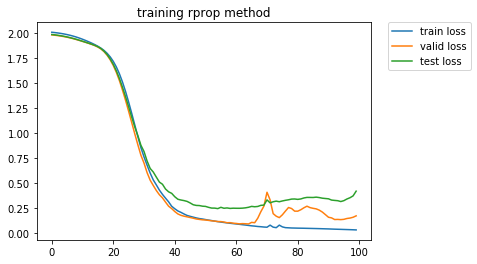

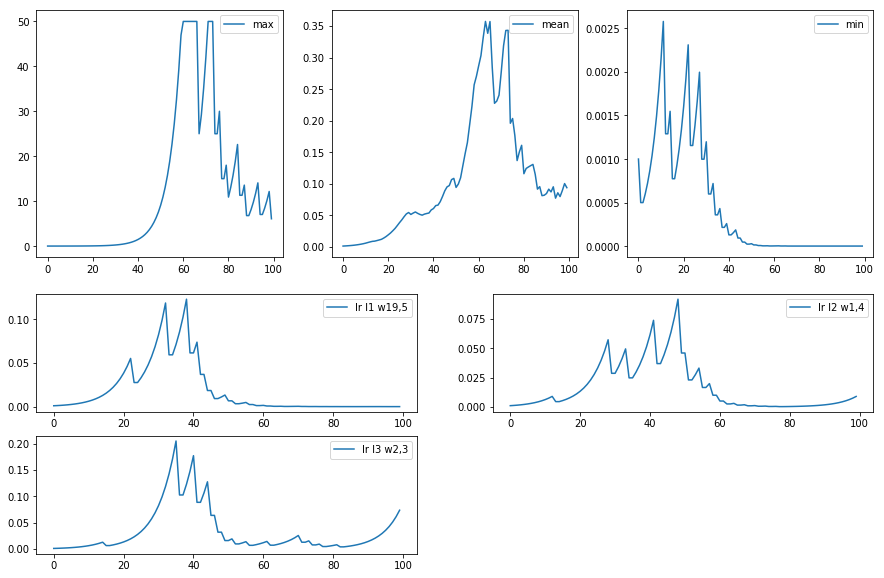

In [143]:
lrv = np.array([0.001])
a1, a2, a3, a4, a5, a6 = [], [], [], [], [], []
a1, a2, a3, a4, a5, a6 = learnRprop(train_data, valid_data, test_data, lrv, 100)

In [131]:
def get_lr(state, lr, betas):
    beta1, beta2 = betas
    exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
    denom = exp_avg_sq.sqrt().add_(1e-8)
    bias_correction1 = 1 - beta1 ** state['step']
    bias_correction2 = 1 - beta2 ** state['step']
    step_size = lr * math.sqrt(bias_correction2) / bias_correction1
    return torch.addcdiv(torch.zeros(denom.size()), step_size, torch.ones(denom.size()), denom)

def learnAdam(train_data, valid_data, test_data, lrv, epochs, betas):
    for num in range(lrv.shape[0]):
        net = copy.deepcopy(netFirstPointXavier)
        lr = lrv[num]
        x_var = 10000
        min_acc = 1000
        max_acc = -1000
        mean_acc = 0
        lr_l1 = []
        lr_l2 = []
        lr_l3 = []
        lr_l4 = []

        lr_mean = []
        lr_min = []
        lr_max = []
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=betas)
        state = optimizer.state
        loss_train, loss_valid, loss_test = [], [], []
        for iter in range(epochs):
            loss_train_acc = 0
            x = Variable(torch.Tensor(train_data[:,FEATURES_INDEX].tolist()))
            y = Variable(torch.Tensor(toClass(train_data[:,LABEL_INDEX]).tolist())).long()
            y_pred = net(x)   
            loss = loss_fn(y_pred, y)
            loss_train_acc = loss.data[0]    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            x_valid = Variable(torch.Tensor(valid_data[:,FEATURES_INDEX].tolist()))
            y_valid = Variable(torch.Tensor(toClass(valid_data[:,LABEL_INDEX]).tolist())).long()
            x_test = Variable(torch.Tensor(test_data[:,FEATURES_INDEX].tolist()))
            y_test = Variable(torch.Tensor(toClass(test_data[:,LABEL_INDEX]).tolist())).long()
            y_valid_pred = net(x_valid)
            y_test_pred = net(x_test)

            loss_train.append(loss_train_acc)
            loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
            loss_test.append(loss_fn(y_test_pred, y_test).data[0])

            #if loss_valid[-1] < x_var:
            #    x_var = loss_valid[-1]
            #elif loss_valid[-1] - x_var > 0.06:
            #    break

            if((iter + 1) % 1000 == 0):
                print(str(iter + 1) + " done")
            min_acc = 1000
            max_acc = -1000
            mean_acc = 0    
            state_values = list(state.values())
            for k in range(len(state_values)):
                g_matrix = get_lr(state_values[k],lr, betas)
                mean_acc += float(torch.mean(g_matrix))
                max_acc = max(max_acc, float(torch.max(g_matrix)))
                min_acc = min(min_acc, float(torch.min(g_matrix)))
            lr_max.append(max_acc)
            lr_mean.append(mean_acc/len(state_values))
            lr_min.append(min_acc)
            
            g_matrix = get_lr(state_values[0],lr, betas)
            lr_l1.append(float(g_matrix[19, 5]))

            g_matrix = get_lr(state_values[2],lr, betas)
            lr_l2.append(float(g_matrix[1, 4]))

            g_matrix = get_lr(state_values[4],lr, betas)
            lr_l3.append(float(g_matrix[2, 3]))
        
        print("all done")
        plt.plot(loss_train, label = "train loss")
        plt.plot(loss_valid, label = "valid loss")
        plt.plot(loss_test, label = "test loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print(loss_train[-1], loss_valid[-1], loss_test[-1])
        asd1, asd2 = betas
        plt.title("Adam method b1=" + str(asd1) + "  b2=" + str(asd2))
        plt.savefig('Adam/learn_loss ' + str(asd1) + ' ' + str(asd2) + '.png', bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.subplot(4, 2, 5)
        plt.plot(lr_l1, label='lr l1 w19,5')
        plt.legend()

        plt.subplot(4, 2, 6)
        plt.plot(lr_l2, label='lr l2 w1,4')
        plt.legend()

        plt.subplot(4, 2, 7)
        plt.plot(lr_l3, label='lr l3 w2,3')
        plt.legend()

        plt.subplot(2, 3, 1)
        plt.plot(lr_max, label='max')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(lr_mean, label='mean')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(lr_min, label='min')
        plt.legend()
        
        plt.savefig('Adam/lrs' + str(asd1) + ' ' + str(asd2) + '.png', bbox_inches='tight')
        plt.show()
        return lr_l1, lr_l2, lr_l3, lr_max, lr_mean, lr_min

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.2760215997695923 6.565282821655273 2.113623857498169


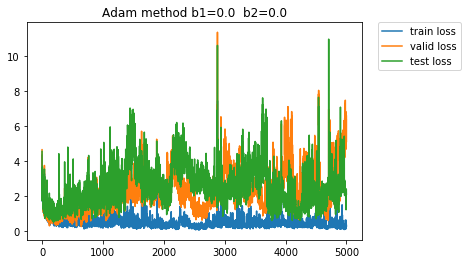

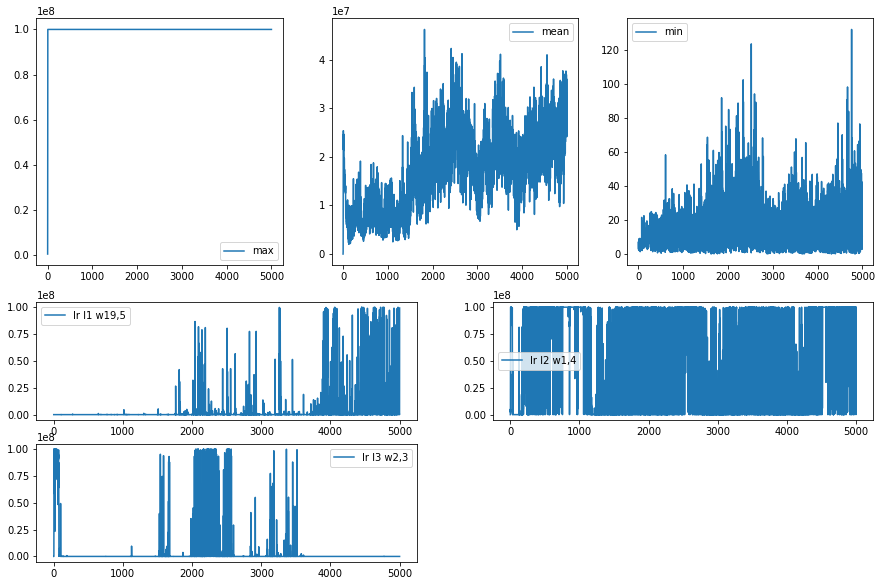

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.07191266119480133 1.1706863641738892 2.4302525520324707


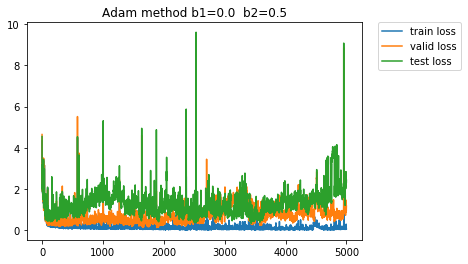

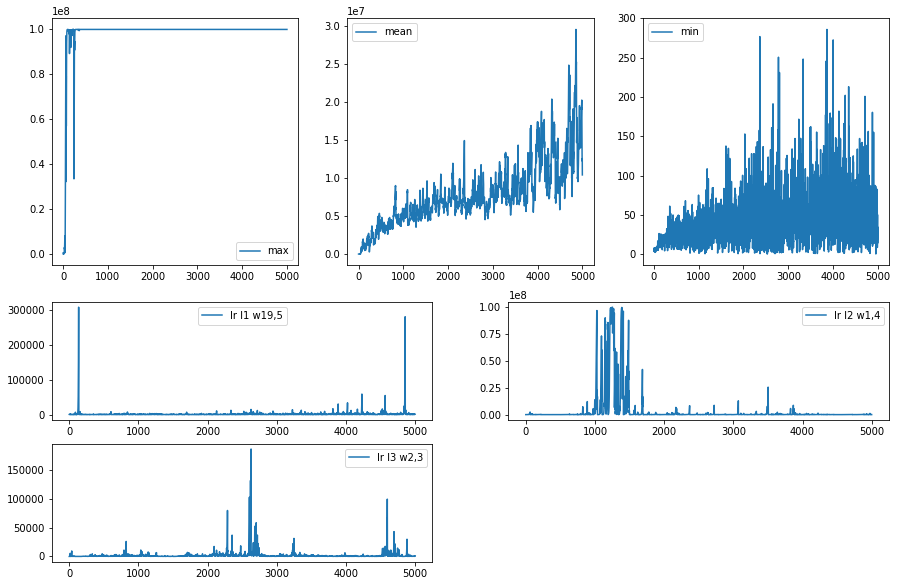

1000 done
2000 done
3000 done
4000 done
5000 done
all done
382.404052734375 387.5857849121094 399.9641418457031


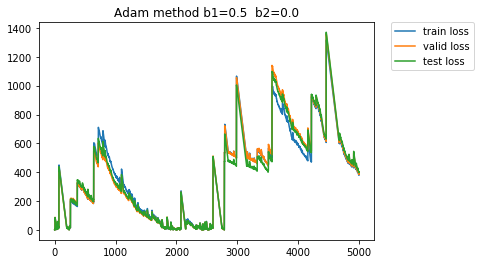

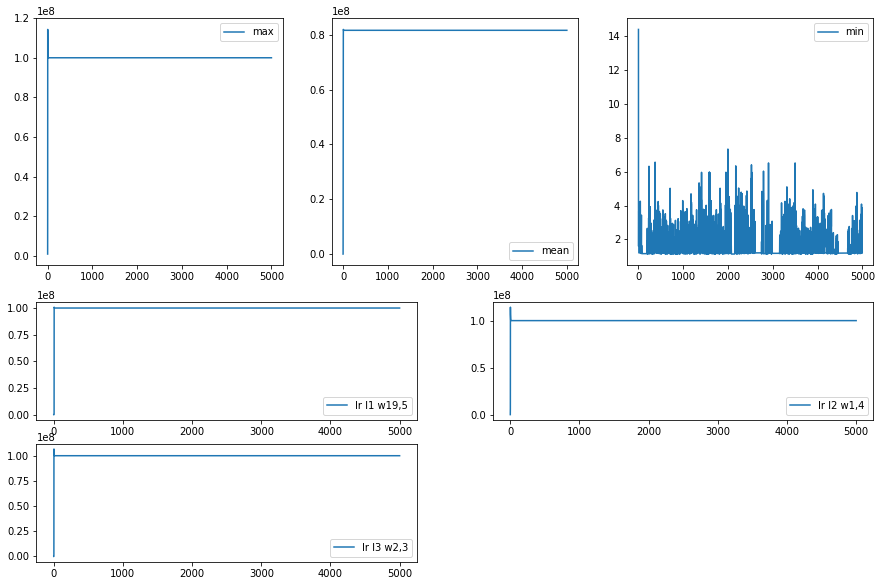

1000 done
2000 done
3000 done
4000 done
5000 done
all done
0.07911671698093414 0.5273569822311401 0.9226858615875244


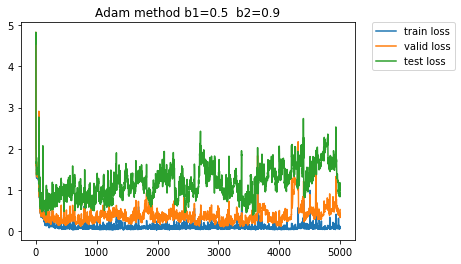

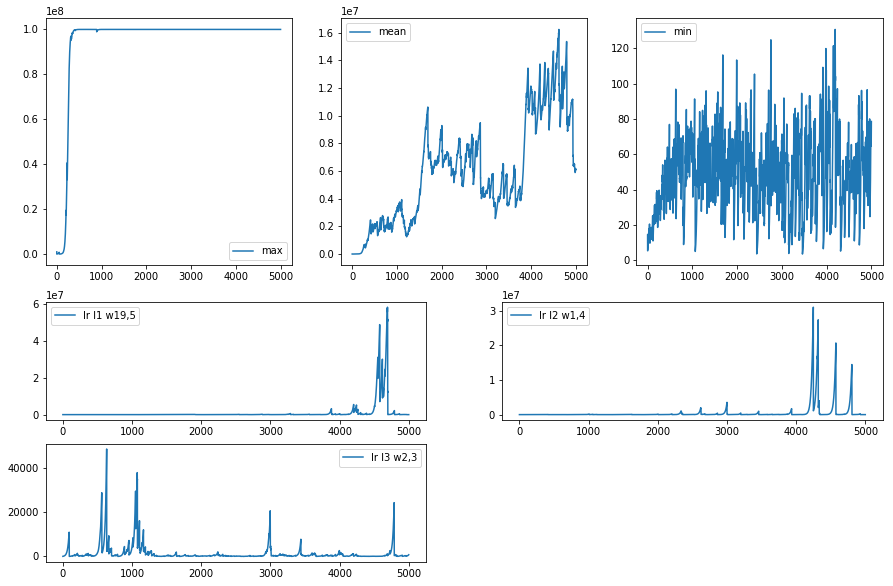

1000 done
2000 done
3000 done
4000 done
5000 done
all done
1.798291563987732 0.7372685670852661 1.0821839570999146


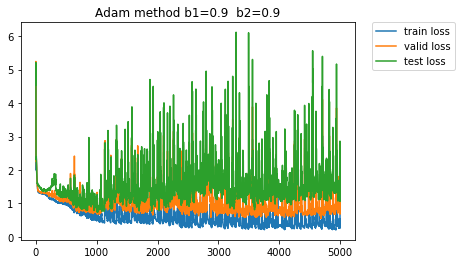

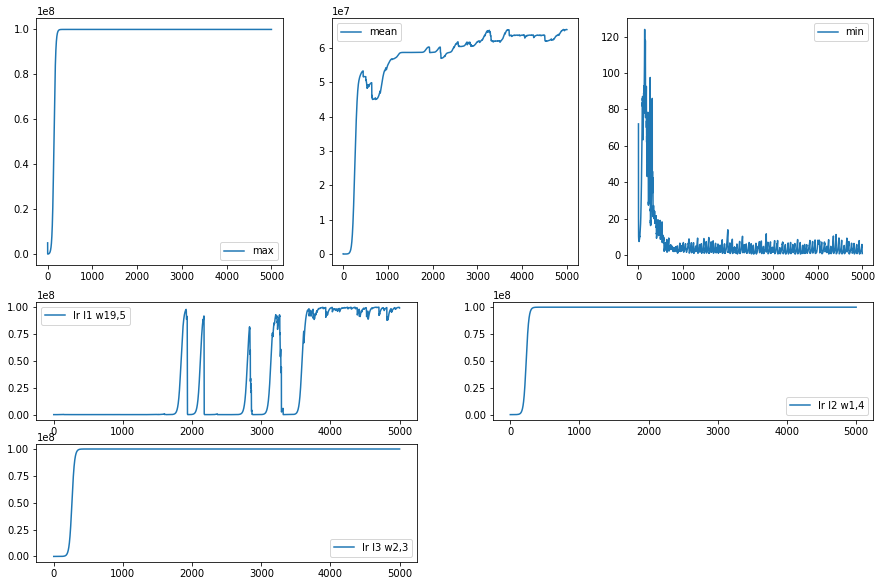

1000 done
2000 done
3000 done
4000 done
5000 done
all done
2.049302816390991 0.6523598432540894 0.9396646618843079


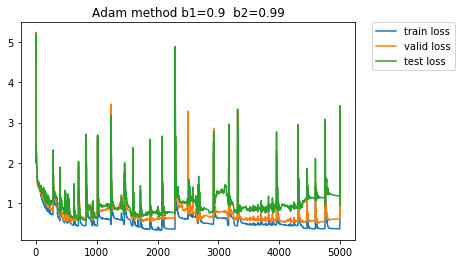

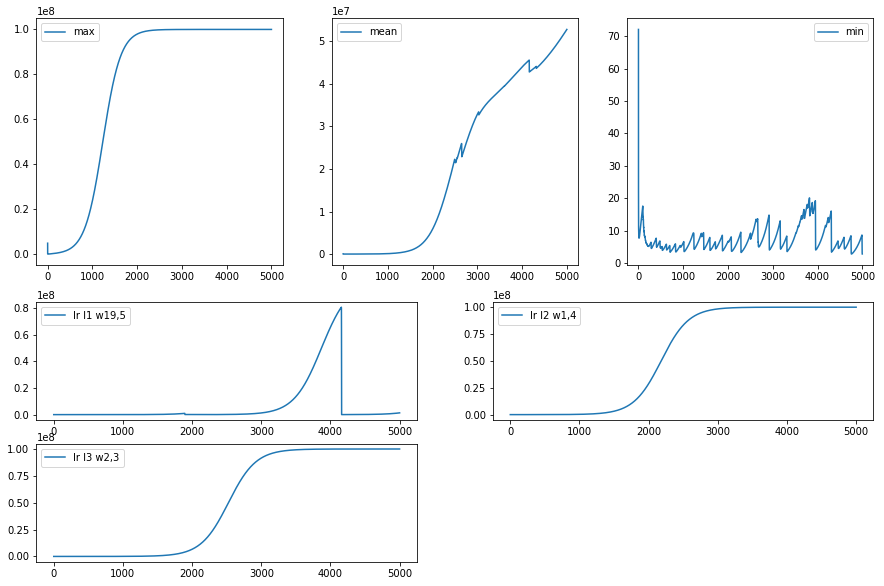

In [132]:
lrv = np.array([1.0])
a1, a2, a3, a4, a5, a6 = [], [], [], [], [], []
a1, a2, a3, a4, a5, a6 = learnAdam(train_data, valid_data, test_data, lrv, 5000, (0.0, 0.0))
lrv = np.array([1.0])
b1, b2, b3, b4, b5, b6 = [], [], [], [], [], []
b1, b2, b3, b4, b5, b6 = learnAdam(train_data, valid_data, test_data, lrv, 5000, (0.0, 0.5))
lrv = np.array([1.0])
c1, c2, c3, c4, c5, c6 = [], [], [], [], [], []
c1, c2, c3, c4, c5, c6 = learnAdam(train_data, valid_data, test_data, lrv, 5000, (0.5, 0.0))
lrv = np.array([1.0])
d1, d2, d3, d4, d5, d6 = [], [], [], [], [], []
d1, d2, d3, d4, d5, d6 = learnAdam(train_data, valid_data, test_data, lrv, 5000, (0.5, 0.9))
lrv = np.array([1.0])
e1, e2, e3, e4, e5, e6 = [], [], [], [], [], []
e1, e2, e3, e4, e5, e6 = learnAdam(train_data, valid_data, test_data, lrv, 5000, (0.9, 0.9))
lrv = np.array([1.0])
f1, f2, f3, f4, f5, f6 = [], [], [], [], [], []
f1, f2, f3, f4, f5, f6 = learnAdam(train_data, valid_data, test_data, lrv, 5000, (0.9, 0.99))

In [230]:
from neupy import environment
from sklearn.model_selection import train_test_split
environment.reproducible()
import theano
###theano.config.floatX = 'float32'
from neupy import algorithms, layers
import pandas as pd
import matplotlib
import theano
import copy
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from neupy import algorithms, layers, init, environment, plots
from neupy.exceptions import StopTraining
#theano.config.floatX = 'float32'
from neupy import plots

In [82]:
eps=0.000001
number_of_epochs=5000
nets={}

In [234]:
learn_params=train_data[:,FEATURES_INDEX]
learn_target=oneHot(train_data[:,LABEL_INDEX])
test_params=test_data[:,FEATURES_INDEX]
test_target=oneHot(test_data[:,LABEL_INDEX])
validation_params=valid_data[:,FEATURES_INDEX]
validation_target=oneHot(valid_data[:,LABEL_INDEX])

In [92]:
#сами реализуйте функцию ошибки, я не смог в нормальном виде из сети результат вытянуть
test_errors=[]
def signal(net):
    test_errors.append(((net.predict(test_params)-test_target)**2).sum()/len(test_target))
    if len(net.errors)>20:
        if abs(net.errors[len(net.errors)-1]-net.errors[len(net.errors)-2]) < eps:
            raise StopTraining("Training has been interrupted")

In [96]:
stepnet=algorithms.GradientDescent(
     connection=[
         layers.Input(11),
         layers.Sigmoid(20, weight=init.XavierNormal(), bias=init.XavierNormal()),
         layers.Sigmoid(10, weight=init.XavierNormal(), bias=init.XavierNormal()),
         layers.Softmax(7, weight=init.XavierNormal(), bias=init.XavierNormal()),
     ],
     search_method='golden',
     error='categorical_crossentropy',
     addons=[algorithms.LinearSearch],
     verbose=True,
     epoch_end_signal=signal,
     shuffle_data=True,
     show_epoch=50
     
)
stepnet.train(learn_params, learn_target, validation_params, validation_target, epochs=number_of_epochs)
plots.error_plot(stepnet)


Main information

[ALGORITHM] GradientDescent

[OPTION] verbose = True
[OPTION] epoch_end_signal = signal
[OPTION] show_epoch = 50
[OPTION] shuffle_data = True
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = ['LinearSearch']
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.37 seconds


In [98]:
weight1=stepnet.layers[1].weight.get_value()
bias1=stepnet.layers[1].bias.get_value()
weight2=stepnet.layers[2].weight.get_value()
bias2=stepnet.layers[2].bias.get_value()
weight3=stepnet.layers[3].weight.get_value()
bias3=stepnet.layers[3].bias.get_value()

In [99]:
stepnet.train(learn_params, learn_target, validation_params, validation_target, epochs=number_of_epochs)


Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Total epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      1.9619 |      1.9888 |      182 ms |
|          50 |     0.62459 |     0.61379 |      187 ms |
|         100 |     0.36473 |     0.34433 |      242 ms |
|         150 |     0.23904 |     0.22441 |      187 ms |
|         200 |      0.1878 |     0.17714 |      172 ms |
|         250 |     0.15947 |     0.15097 |      187 ms |
|         300 |     0.14147 |     0.13415 |      187 ms |
|         350 |      0.1287 |     0.12215 |      187 ms |
|         400 |     0.11923 |     0.11342 |      187 ms |
|         450 |     0.11175 |     0.10664 |      172 ms |
|         500 |     0.10563 |     0.10117 |      203 ms |
|         550 |     0.10041 |    0.096557 |      187 ms |
|         600 |  

sgd train error 0.0206836545633
sgd test error 0.0815241895739


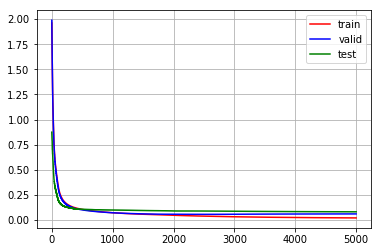

In [101]:
print("sgd train error "+str(stepnet.train_errors.last()))
print("sgd test error "+str(test_errors[len(test_errors)-1]))
plt.clf()
plt.grid(True)
plt.plot(stepnet.train_errors, color='r', label='train') 
plt.plot(stepnet.validation_errors, color='b', label='valid') 
plt.plot(test_errors, color='g', label='test')
plt.legend()
plt.savefig('SGD_train_valid_test.png', bbox_inches='tight')
nets["sgd"]=stepnet.last_epoch
plt.show()

In [102]:
test_errors=[]
fletchernet = algorithms.ConjugateGradient(
     connection=[
         layers.Input(11),
         layers.Sigmoid(20, weight=copy.deepcopy(weight1), bias=copy.deepcopy(bias1)),
         layers.Sigmoid(10, weight=copy.deepcopy(weight2), bias=copy.deepcopy(bias2)),
         layers.Softmax(7, weight=copy.deepcopy(weight3), bias=copy.deepcopy(bias3)),
     ],
     search_method='golden',
     update_function='fletcher_reeves',
     error='categorical_crossentropy',
     shuffle_data=False,
     addons=[algorithms.LinearSearch],
     step=0.01,
     verbose=True,
     epoch_end_signal=signal,
     show_epoch=50
 )


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = signal
[OPTION] show_epoch = 50
[OPTION] shuffle_data = False
[OPTION] step = 0.01
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 11.32 seconds


In [103]:
fletchernet.train(learn_params, learn_target, validation_params, validation_target, epochs=number_of_epochs)


Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Total epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      1.9619 |      1.9888 |      220 ms |
|          50 |      0.0678 |    0.075941 |      114 ms |
|         100 |    0.024134 |    0.084399 |      109 ms |
|         150 |   0.0092152 |    0.087915 |      125 ms |
|         200 |   0.0023671 |     0.14473 |      141 ms |
|         250 |   0.0011653 |     0.15272 |      102 ms |
|         300 |  0.00060316 |     0.15739 |       94 ms |
|         350 |  0.00034308 |     0.16664 |      109 ms |
|         400 |  0.00020594 |     0.17622 |      117 ms |
---------------------------------------------------------
[TRAIN] Epoch #433 stopped. Training has been interrupted
|         433 |  0.00014198 |     0.18088 |      109 ms |



fletcher train error 0.000141982829561
fletcher test error 0.109488850346


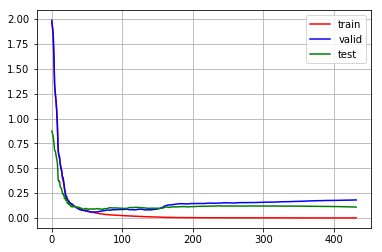

In [105]:
print("fletcher train error "+str(fletchernet.train_errors.last()))
print("fletcher test error "+str(test_errors[len(test_errors)-1]))
plt.clf()
plt.grid(True)
plt.plot(fletchernet.train_errors, color='r', label='train') 
plt.plot(fletchernet.validation_errors, color='b', label='valid') 
plt.plot(test_errors, color='g', label='test')
plt.legend()
plt.savefig('Fletcher_train_valid_test.png', bbox_inches='tight')
nets["fletcher"]=fletchernet.last_epoch
plt.show()

In [106]:
test_errors=[]
polaknet = algorithms.ConjugateGradient(
     connection=[
         layers.Input(11),
         layers.Sigmoid(20, weight=copy.deepcopy(weight1), bias=copy.deepcopy(bias1)),
         layers.Sigmoid(10, weight=copy.deepcopy(weight2), bias=copy.deepcopy(bias2)),
         layers.Softmax(7, weight=copy.deepcopy(weight3), bias=copy.deepcopy(bias3)),
     ],
     search_method='golden',
     update_function='polak_ribiere',
     error='categorical_crossentropy',
     shuffle_data=False,
     addons=[algorithms.LinearSearch],
     verbose=True,
     epoch_end_signal=signal,
     show_epoch=50
 )


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = signal
[OPTION] show_epoch = 50
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = polak_ribiere
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.34 seconds


In [107]:
polaknet.train(learn_params, learn_target, validation_params, validation_target, epochs=number_of_epochs)


Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Total epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      1.9619 |      1.9888 |      119 ms |
|          50 |    0.062004 |    0.088474 |      132 ms |
|         100 |    0.025268 |     0.14907 |      125 ms |
|         150 |   0.0085909 |     0.16911 |      101 ms |
|         200 |   0.0033796 |     0.17629 |      109 ms |
|         250 |   0.0011674 |     0.30514 |      101 ms |
|         300 |  0.00042793 |     0.36497 |      119 ms |
---------------------------------------------------------
[TRAIN] Epoch #343 stopped. Training has been interrupted
|         343 |  0.00015346 |     0.38286 |       93 ms |



polak train error 0.000153462624922
polak test error 0.133304993876


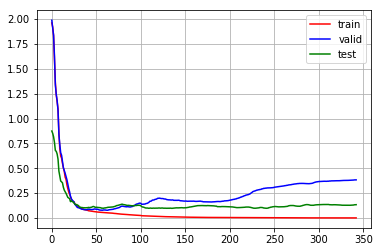

In [108]:
print("polak train error "+str(polaknet.train_errors.last()))
print("polak test error "+str(test_errors[len(test_errors)-1]))
plt.clf()
plt.grid(True)
plt.plot(polaknet.train_errors, color='r', label='train') 
plt.plot(polaknet.validation_errors, color='b', label='valid') 
plt.plot(test_errors, color='g', label='test')
plt.legend()
plt.savefig('Polak_train_valid_test.png', bbox_inches='tight')
nets["polak"]=polaknet.last_epoch
plt.show()

In [146]:
test_errors=[]
bfgsnet = algorithms.QuasiNewton(
     connection=[
         layers.Input(11),
         layers.Sigmoid(20, weight=copy.deepcopy(weight1), bias=copy.deepcopy(bias1)),
         layers.Sigmoid(10, weight=copy.deepcopy(weight2), bias=copy.deepcopy(bias2)),
         layers.Softmax(7, weight=copy.deepcopy(weight3), bias=copy.deepcopy(bias3)),
     ],
     update_function='bfgs',
     error='categorical_crossentropy',
     h0_scale=1,
     epoch_end_signal=signal,
     shuffle_data=True,
     show_epoch=50,
     verbose=True
 )


Main information

[ALGORITHM] QuasiNewton

[OPTION] verbose = True
[OPTION] epoch_end_signal = signal
[OPTION] show_epoch = 50
[OPTION] shuffle_data = True
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None
[OPTION] h0_scale = 1
[OPTION] update_function = bfgs

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 16.67 seconds


In [147]:
bfgsnet.train(learn_params, learn_target, validation_params, validation_target, epochs=100)


Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      2.2993 |       2.024 |       19 ms |
|          50 |     0.21621 |     0.23873 |       22 ms |
|         100 |    0.074137 |     0.26143 |       16 ms |
---------------------------------------------------------



bfgs train error 0.0290350942756
bfgs test error 0.165262595213


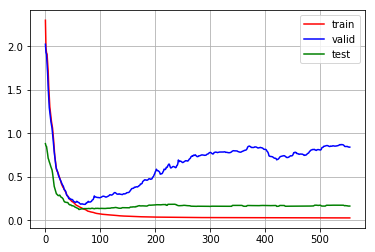

In [135]:
print("bfgs train error "+str(bfgsnet.train_errors.last()))
print("bfgs test error "+str(test_errors[len(test_errors)-1]))
plt.clf()
plt.grid(True)
plt.plot(bfgsnet.train_errors, color='r', label='train') 
plt.plot(bfgsnet.validation_errors, color='b', label='valid') 
plt.plot(test_errors, color='g', label='test')
plt.legend()
plt.savefig('Bfgs_train_valid_test.png', bbox_inches='tight')
nets["bfgs"]=bfgsnet.last_epoch
plt.show()

In [142]:
test_errors=[]
lmnet = algorithms.LevenbergMarquardt(
     connection=[
         layers.Input(11),
         layers.Sigmoid(20, weight=copy.deepcopy(weight1), bias=copy.deepcopy(bias1)),
         layers.Sigmoid(10, weight=copy.deepcopy(weight2), bias=copy.deepcopy(bias2)),
         layers.Softmax(7, weight=copy.deepcopy(weight3), bias=copy.deepcopy(bias3)),
     ],
     epoch_end_signal=signal,
     shuffle_data=True,
     mu=0.5,
     error='categorical_crossentropy',
     mu_update_factor=1.3,
     show_epoch=50,
     verbose=True
 )

ValueError: Wrong value `categorical_crossentropy` for property `error`. Available values: mse

In [137]:
lmnet.train(learn_params, learn_target, validation_params, validation_target, epochs=number_of_epochs)


Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Total epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |     0.13853 |     0.15348 |       1 sec |
---------------------------------------------------------
[TRAIN] Epoch #21 stopped. Training has been interrupted
|          21 |     0.24692 |      0.2373 |       1 sec |



lm train error 0.246916352276
lm test error 1.67838974027


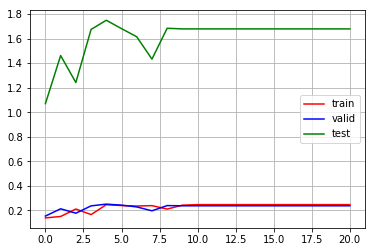

In [139]:
print("lm train error "+str(lmnet.train_errors.last()))
print("lm test error "+str(test_errors[len(test_errors)-1]))
plt.clf()
plt.grid(True)
plt.plot(lmnet.train_errors, color='r', label='train') 
plt.plot(lmnet.validation_errors, color='b', label='valid') 
plt.plot(test_errors, color='g', label='test')
plt.legend()
plt.savefig('LM_train_valid_test.png', bbox_inches='tight')
nets["lm"]=lmnet.last_epoch
plt.show()

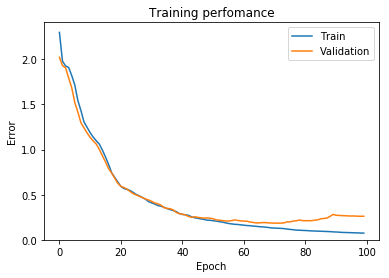

In [148]:
plots.error_plot(bfgsnet)

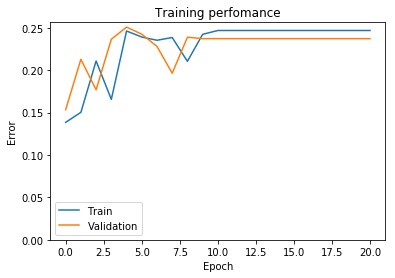

In [141]:
plots.error_plot(lmnet)

In [65]:
from sklearn import metrics
y_predicted = network.predict(valid_data[:,FEATURES_INDEX]).argmax(axis=1)
y_test = np.asarray(oneHot(valid_data[:,LABEL_INDEX]).argmax(axis=1)).reshape(valid_data.shape[0])
print(metrics.classification_report(y_test, y_predicted))
score = metrics.accuracy_score(y_test, y_predicted)
print("Validation accuracy: {:.2%}".format(score))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       101
          1       1.00      1.00      1.00        86
          2       0.99      1.00      0.99        70
          3       0.97      0.97      0.97        96
          4       0.98      0.94      0.96        85
          5       1.00      1.00      1.00        91
          6       1.00      1.00      1.00        67

avg / total       0.99      0.99      0.99       596

Validation accuracy: 98.66%


In [166]:
def asdasd(bs):
    mgdnet = algorithms.MinibatchGradientDescent(
         connection=[
             layers.Input(11),
             layers.Sigmoid(20, weight=copy.deepcopy(weight1), bias=copy.deepcopy(bias1)),
             layers.Sigmoid(10, weight=copy.deepcopy(weight2), bias=copy.deepcopy(bias2)),
             layers.Softmax(7, weight=copy.deepcopy(weight3), bias=copy.deepcopy(bias3)),
         ],
        error='categorical_crossentropy',
        step=1.0,
        verbose=True,
        shuffle_data=True,
        show_epoch=200,
        #momentum=0.99,
        #nesterov=True,
        batch_size=bs

    )
    mgdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=5000, epsilon = 0.00001)
    plots.error_plot(mgdnet)


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 1
[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 200
[OPTION] shuffle_data = True
[OPTION] step = 1.0
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.40 seconds

Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Epsilon: 1e-05, Max epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           0 |      1.1561 |      1.3804 |       70 ms |


|         200 |     0.41732 |     0.48407 |       76 ms |


|         400 |     0.36409 |     0.38436 |       75 ms |


|         600 |     0.27366 |     0.44477 |       76 ms |


|         800 |     0.42992 |     0.55017 |       71 ms |


|        1000 |     0.36474 |     0.38229 |       86 ms |


|        1200 |     0.35642 |     0.59083 |       78 ms |


|        1400 |     0.30558 |     0.47379 |       76 ms |


|        1600 |     0.32993 |     0.54948 |       85 ms |


|        1800 |     0.35136 |     0.57471 |       78 ms |


|        2000 |     0.32568 |     0.53801 |       76 ms |


|        2200 |     0.32975 |     0.50236 |       75 ms |


[TRAIN] Epoch #2270 interrupted. Network converged.
|        2270 |     0.32775 |      0.6977 |       77 ms |
---------------------------------------------------------



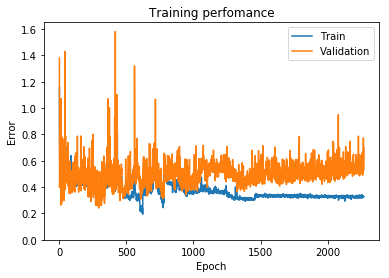

In [167]:
asdasd(1)


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 20
[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 200
[OPTION] shuffle_data = True
[OPTION] step = 1.0
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.38 seconds

Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Epsilon: 1e-05, Max epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           0 |      1.5646 |      1.1859 |        9 ms |


|         200 |    0.020507 |     0.16338 |        9 ms |


|         400 |   0.0055976 |     0.11894 |        9 ms |
[TRAIN] Epoch #427 interrupted. Network converged.
|         427 |   0.0070531 |     0.12161 |        9 ms |
---------------------------------------------------------



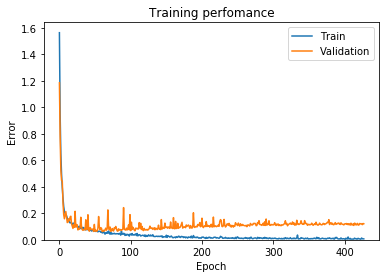

In [168]:
asdasd(20)


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 100
[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 200
[OPTION] shuffle_data = True
[OPTION] step = 1.0
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.38 seconds

Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Epsilon: 1e-05, Max epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           0 |      1.9425 |       1.811 |        7 ms |


|         200 |    0.050143 |      0.0644 |        6 ms |


|         400 |    0.022897 |    0.067301 |        5 ms |


|         600 |    0.013896 |    0.089448 |        6 ms |
|         800 |   0.0089202 |     0.10531 |        6 ms |
|        1000 |    0.011057 |     0.10287 |        5 ms |
[TRAIN] Epoch #1177 interrupted. Network converged.
|        1177 |   0.0073352 |     0.12068 |        5 ms |
---------------------------------------------------------



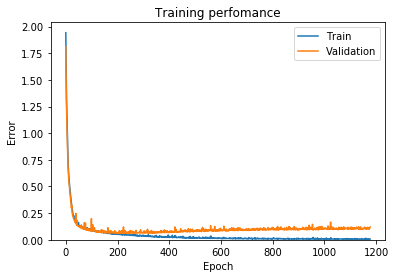

In [169]:
asdasd(100)


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 1193
[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 200
[OPTION] shuffle_data = True
[OPTION] step = 1.0
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.39 seconds

Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Epsilon: 1e-05, Max epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           0 |      2.2993 |       2.024 |        6 ms |
|         200 |     0.46174 |     0.44023 |        5 ms |
|         400 |     0.19376 |     0.18185 |        6 ms |
|         600 |     0.12926 |     0.12219 |        5 ms |
|         800 |     0.10352 | 

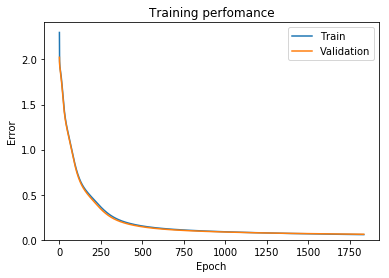

In [170]:
asdasd(train_data.shape[0])

D:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


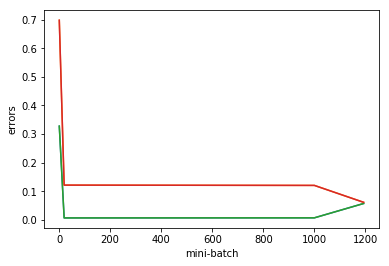

In [176]:
plt.plot([1,20,1000,train_data.shape[0]],[0.3277,0.0070,0.0073,0.0574])
plt.plot([1,20,1000,train_data.shape[0]],[0.6977,0.1216,0.1206,0.0615])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("mini-batch")
plt.ylabel("errors")
plt.savefig('aaa.png', bbox_inches='tight')
plt.show()


In [174]:
train_data.shape[0]

1193

In [187]:
def stolbGist(val_, names_, title, label_):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    dpi = 80
    fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
    mpl.rcParams.update({'font.size': 10})

    plt.title(title)

    ax = plt.axes()
    ax.yaxis.grid(True, zorder = 1)

    xs = range(len(names_))

    plt.bar([x + 0.05 for x in xs], [ d for d in val_],
            width = 0.2, color = 'red', alpha = 0.7, label = label_,
            zorder = 2)
    plt.xticks(xs, names_)

    fig.autofmt_xdate(rotation = 25)

    plt.legend(loc='upper right')
    fig.savefig('bars.png')
    plt.show()

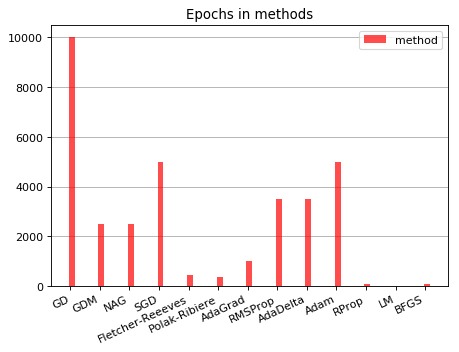

In [188]:
epochs_ = [10000, 2500, 2500, 5000, 450, 350, 1000, 3500, 3500, 5000, 100, 21, 100]
names_ = ['GD', 'GDM', 'NAG', 'SGD', 'Fletcher-Reeeves', 'Polak-Ribiere',
          'AdaGrad', 'RMSProp', 'AdaDelta', 'Adam', 'RProp','LM','BFGS']
stolbGist(epochs_, names_, 'Epochs in methods', 'method')

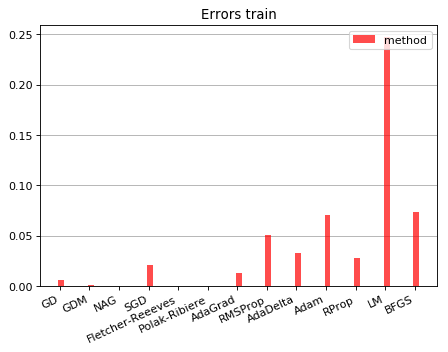

In [192]:
errors_train = [0.006,0.0007,0.0006, 0.0206, 0.00014, 0.00015, 0.0130, 0.0504,0.03289,0.071,0.0280,0.2469,0.074]
errors_test = [0.1584, 0.2671, 0.2634, 0.0815, 0.1094, 0.1333, 0.2712, 0.8900,0.17559,0.922,0.4166,0.2373,0.2614]
stolbGist(errors_train, names_, 'Errors train', 'method')

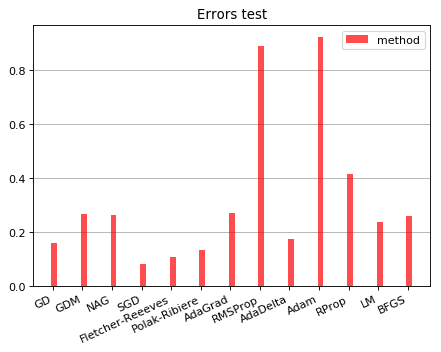

In [193]:
stolbGist(errors_test, names_, 'Errors test', 'method')

In [21]:
#asdsadsadad
#asdsadsadad
#asdsadsadad
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import collections
from torch.nn.parameter import Parameter

In [22]:
LOSS_THRESHOLD = 1e-6

In [24]:
#train_data.dtype = np.float32
#train_data_ = np.zeros((train_data.shape[0], train_data.shape[1]), dtype=np.float32)
#valid_data_ = np.zeros((valid_data.shape[0], train_data.shape[1]), dtype=np.float32)
#test_data_ = np.zeros((test_data.shape[0], train_data.shape[1]), dtype=np.float32)
learn_dataloader = DataLoader(train_data, batch_size=1, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=len(valid_data), shuffle=False)

In [146]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(11, 20)
        self.lin2 = nn.Linear(20, 10)
        self.lin3 = nn.Linear(10, 7)
        self.f1 = nn.Sigmoid()
        self.f2 = nn.Sigmoid()

    def forward(self, x):
        self.h1 = self.f1(self.lin1(x))
        self.h2 = self.f2(self.lin2(self.h1))
        self.h3 = self.lin3(self.h2)
        return self.h3

net = Net()
net

Net (
  (lin1): Linear (11 -> 20)
  (lin2): Linear (20 -> 10)
  (lin3): Linear (10 -> 7)
  (f1): Sigmoid ()
  (f2): Sigmoid ()
)

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [148]:
h_mean_collection_by_sigma = collections.defaultdict(list)
h_std_collection_by_sigma = collections.defaultdict(list)
g_mean_collection_by_sigma = collections.defaultdict(list)
g_std_collection_by_sigma = collections.defaultdict(list)

In [149]:
#функции инициализация весов
from torch.nn import init
sigma_list = [0.0001, 0.01, 0.1, 0.5, 1, 2, 5, 10]
act_func_layers = ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        if sigma == 'Xavier':
            nn.init.xavier_normal(layer.weight.data, torch.nn.init.calculate_gain(tmp_act_fun.pop(0)))
            layer.bias.data.fill_(0.0)
        else:
            nn.init.normal(layer.weight.data, mean=0, std=sigma)
            nn.init.normal(layer.bias.data, mean=0, std=sigma)
            
index_list = [(1, 0), (2, 0), (3, 0)]

for epoch in range(50):
    print(epoch)
    #выход
    h_by_sigma = collections.defaultdict(list)
    #град
    g_by_sigma = collections.defaultdict(list)

    for sigma in sigma_list:
        tmp_act_fun = list(act_func_layers)
        net.apply(init_weigths)
        h_by_example = collections.defaultdict(list)
        g_by_example = collections.defaultdict(list)

        for i in range(train_data.shape[0]):
            
            ar_ = np.zeros((1))
            ar_[0] = toNumClass(train_data[i,LABEL_INDEX])
            kostil2_ = np.zeros((1,11))
            kostil2_[0,:] = train_data[i,FEATURES_INDEX]
            
            features = Variable(torch.Tensor(kostil2_.tolist()))
            labels = Variable(torch.Tensor(ar_.tolist())).long()
            #features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            
            features.requres_grad = True
            labels.requres_grad = True
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            for neuron in index_list:
                layer, num_neur = neuron
                if layer == 1:
                    h_by_example[neuron] += [float(net.h1[:, num_neur].data.cpu().numpy())] 
                    g_by_example[neuron] += [float(net.lin1.weight.grad[num_neur, 0].data.cpu().numpy() / features[:, 0].data.cpu().numpy())]
                elif layer == 2:
                    h_by_example[neuron] += [float(net.h2[:, num_neur].data.cpu().numpy())]
                    g_by_example[neuron] += [float(net.lin2.weight.grad[num_neur, 0].data.cpu().numpy() / net.h1[:, 0].data.cpu().numpy())]
                elif layer == 3:
                    h_by_example[neuron] += [float(net.h3[:, num_neur].data.cpu().numpy())]
                    g_by_example[neuron] += [float(net.lin3.weight.grad[num_neur, 0].data.cpu().numpy() / net.h2[:, 0].data.cpu().numpy())]
        h_by_sigma[sigma] += [h_by_example]
        g_by_sigma[sigma] += [g_by_example]

    for neuron in index_list:
        for sigma in sigma_list:    
            h_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(h_by_sigma[sigma][0][neuron])]
            h_std_collection_by_sigma[(sigma, neuron)]  += [np.std(h_by_sigma[sigma][0][neuron])]
            g_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(g_by_sigma[sigma][0][neuron])]
            g_std_collection_by_sigma[(sigma, neuron)]  += [np.std(g_by_sigma[sigma][0][neuron])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [150]:
xavier_h_mean_collection_by_sigma = collections.defaultdict(list)
xavier_h_std_collection_by_sigma = collections.defaultdict(list)
xavier_g_mean_collection_by_sigma = collections.defaultdict(list)
xavier_g_std_collection_by_sigma = collections.defaultdict(list)

In [151]:
for epoch in range(50):
    print(epoch)
    #выход
    h_by_sigma = collections.defaultdict(list)
    #град
    g_by_sigma = collections.defaultdict(list)

    for sigma in ['Xavier']:
        tmp_act_fun = list(act_func_layers)
        net.apply(init_weigths)
        h_by_example = collections.defaultdict(list)
        g_by_example = collections.defaultdict(list)

        for i in range(train_data.shape[0]):
            
            ar_ = np.zeros((1))
            ar_[0] = toNumClass(train_data[i,LABEL_INDEX])
            kostil2_ = np.zeros((1,11))
            kostil2_[0,:] = train_data[i,FEATURES_INDEX]
            
            features = Variable(torch.Tensor(kostil2_.tolist()))
            labels = Variable(torch.Tensor(ar_.tolist())).long()
            #features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            
            features.requres_grad = True
            labels.requres_grad = True
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            for neuron in index_list:
                layer, num_neur = neuron
                if layer == 1:
                    h_by_example[neuron] += [float(net.h1[:, num_neur].data.cpu().numpy())] 
                    g_by_example[neuron] += [float(net.lin1.weight.grad[num_neur, 0].data.cpu().numpy() / features[:, 0].data.cpu().numpy())]
                elif layer == 2:
                    h_by_example[neuron] += [float(net.h2[:, num_neur].data.cpu().numpy())]
                    g_by_example[neuron] += [float(net.lin2.weight.grad[num_neur, 0].data.cpu().numpy() / net.h1[:, 0].data.cpu().numpy())]
                elif layer == 3:
                    h_by_example[neuron] += [float(net.h3[:, num_neur].data.cpu().numpy())]
                    g_by_example[neuron] += [float(net.lin3.weight.grad[num_neur, 0].data.cpu().numpy() / net.h2[:, 0].data.cpu().numpy())]
        h_by_sigma[sigma] += [h_by_example]
        g_by_sigma[sigma] += [g_by_example]

    for neuron in index_list:
        for sigma in ['Xavier']:    
            xavier_h_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(h_by_sigma[sigma][0][neuron])]
            xavier_h_std_collection_by_sigma[(sigma, neuron)]  += [np.std(h_by_sigma[sigma][0][neuron])]
            xavier_g_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(g_by_sigma[sigma][0][neuron])]
            xavier_g_std_collection_by_sigma[(sigma, neuron)]  += [np.std(g_by_sigma[sigma][0][neuron])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.188993475068
0.0489817871922
0.0473598263105


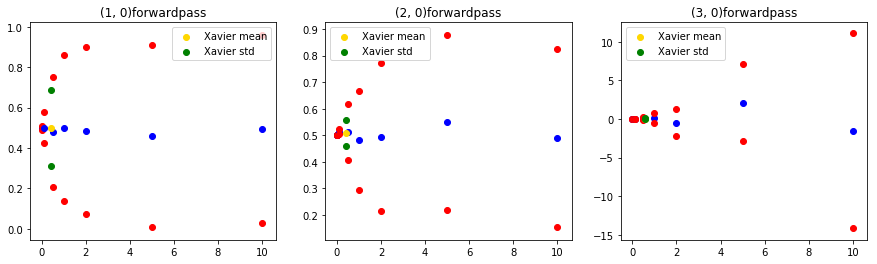

In [152]:
#прямой поток
plt.figure(figsize=(15,4))
plt.title('forwardpass')
for num, neuron in enumerate(index_list):
    plt.subplot(1, 3, num+1)
    for sigma in sigma_list:
        h_mean__ = np.mean(h_mean_collection_by_sigma[(sigma,neuron)])
        h_std__ = np.mean(h_std_collection_by_sigma[(sigma,neuron)])
        plt.scatter(sigma, h_mean__, c='b')
        plt.scatter(sigma, h_mean__ + h_std__, c='r')
        plt.scatter(sigma, h_mean__ - h_std__, c='r')
    h_mean__ = np.mean(xavier_h_mean_collection_by_sigma[('Xavier',neuron)])
    h_std__ = np.mean(xavier_h_std_collection_by_sigma[('Xavier',neuron)])
    #подсчет сигма
    if neuron[0] == 1:
        xavier_sigma = (5/3) * (2/(20+11))**(1/2)
    elif neuron[0] == 2:
        xavier_sigma = (5/3) * (2/(20+10))**(1/2)
    elif neuron[0] == 3:
        xavier_sigma = (5/3) * (2/(10+7))**(1/2)
    plt.scatter(xavier_sigma, h_mean__, c='gold', label = 'Xavier mean')
    plt.scatter(xavier_sigma, h_mean__+h_std__, c='green', label = 'Xavier std')
    plt.scatter(xavier_sigma, h_mean__-h_std__, c='green')
    print(h_std__)
    plt.legend()
    plt.title(str(neuron)+'forwardpass')
plt.savefig('flow_forward.png', bbox_inches='tight')
plt.show()

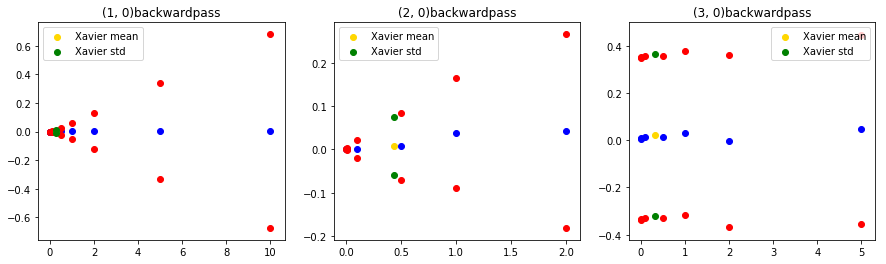

In [155]:
#обратный поток
plt.figure(figsize=(15,4))
plt.title('backwardpass')
for num, neuron in enumerate(index_list):
    plt.subplot(1, 3, num+1)
    for sigma in sigma_list:
        g_mean = np.mean(g_mean_collection_by_sigma[(sigma,neuron)])
        g_std = np.mean(g_std_collection_by_sigma[(sigma,neuron)])
        plt.scatter(sigma, g_mean, c='b')
        plt.scatter(sigma, g_mean+g_std, c='r')
        plt.scatter(sigma, g_mean-g_std, c='r')
    g_mean = np.mean(xavier_g_mean_collection_by_sigma[('Xavier',neuron)])
    g_std = np.mean(xavier_g_std_collection_by_sigma[('Xavier',neuron)])
    #подсчет сигма
    if neuron[0] == 1:
        sigma = (5/3) * (2/(20+50))**(1/2)
    elif neuron[0] == 2:
        sigma = (5/3) * (2/(20+10))**(1/2)
    elif neuron[0] == 3:
        sigma = (2/(10+10))**(1/2)
    plt.scatter(sigma, g_mean, c='gold', label = 'Xavier mean')
    plt.scatter(sigma, g_mean+g_std, c='g', label = 'Xavier std')
    plt.scatter(sigma, g_mean-g_std, c='g')
    plt.legend()
    plt.title(str(neuron)+'backwardpass')
plt.savefig('flow_backward.png', bbox_inches='tight')
plt.show()

In [163]:
#функции инициализация весов
#выход
hist_h_by_sigma = collections.defaultdict(list)
#град
hist_g_by_sigma = collections.defaultdict(list)

for sigma in [0.0001, 'Xavier', 10]:
    tmp_act_fun = list(act_func_layers)
    net.apply(init_weigths)
    h_by_example = collections.defaultdict(list)
    g_by_example = collections.defaultdict(list)

    for i in range(train_data.shape[0]):
            
        ar_ = np.zeros((1))
        ar_[0] = toNumClass(train_data[i,LABEL_INDEX])
        kostil2_ = np.zeros((1,11))
        kostil2_[0,:] = train_data[i,FEATURES_INDEX]
            
        features = Variable(torch.Tensor(kostil2_.tolist()))
        labels = Variable(torch.Tensor(ar_.tolist())).long()
        #features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            
        features.requres_grad = True
        labels.requres_grad = True
        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        for neuron in index_list:
            layer, num_neur = neuron
            if layer == 1:
                h_by_example[neuron] += [float(net.h1[:, num_neur].data.cpu().numpy())]
                g_by_example[neuron] += [float(net.lin1.weight.grad[num_neur, 0].data.cpu().numpy() / features[:, 0].data.cpu().numpy())]
            elif layer == 2:
                h_by_example[neuron] += [float(net.h2[:, num_neur].data.cpu().numpy())]
                g_by_example[neuron] += [float(net.lin2.weight.grad[num_neur, 0].data.cpu().numpy() / net.h1[:, 0].data.cpu().numpy())]
            elif layer == 3:
                h_by_example[neuron] += [float(net.h3[:, num_neur].data.cpu().numpy())]
                g_by_example[neuron] += [float(net.lin3.weight.grad[num_neur, 0].data.cpu().numpy() / net.h2[:, 0].data.cpu().numpy())]
    hist_h_by_sigma[sigma] += [h_by_example]
    hist_g_by_sigma[sigma] += [g_by_example]

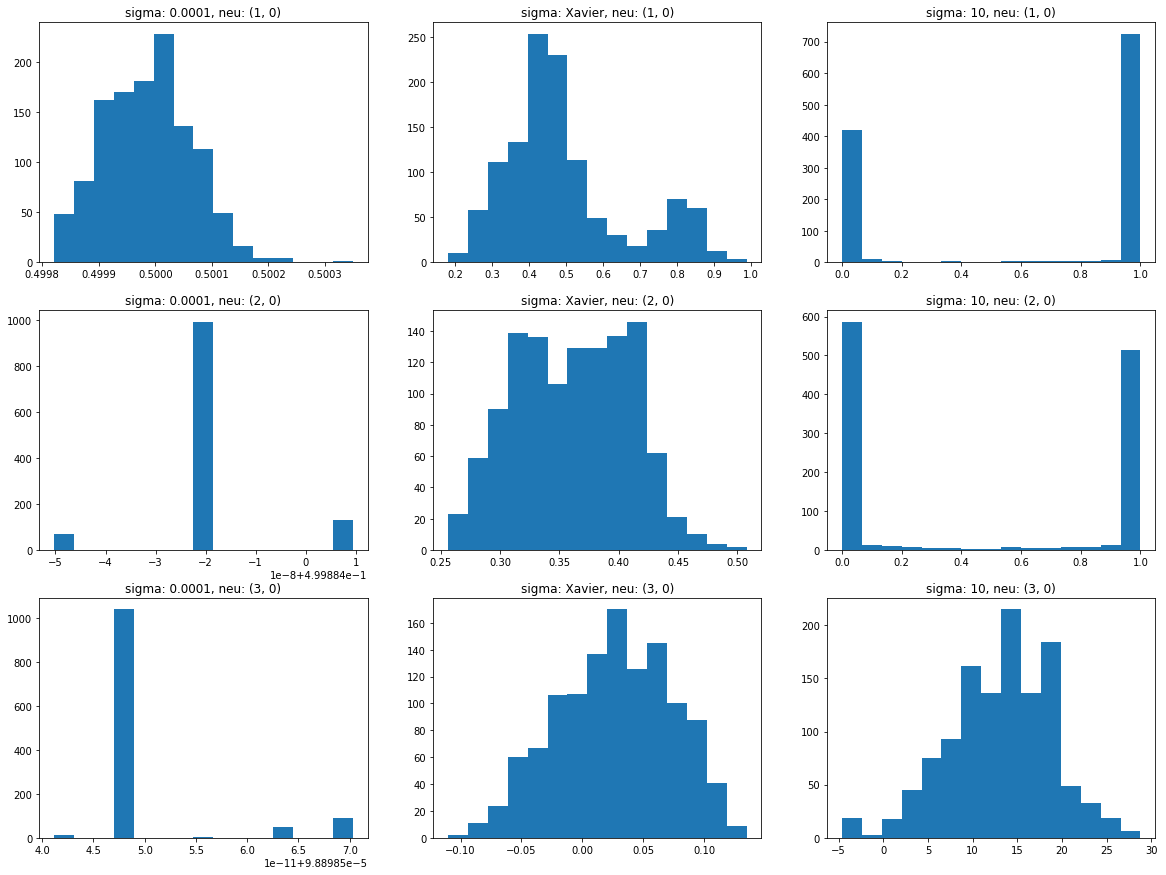

In [216]:
plt.figure(figsize=(20,15))
for num_neuron, neuron in enumerate(index_list):
    for num_sigma, sigma in enumerate([0.0001, 'Xavier', 10]):
        plt.subplot(3, 3, (num_neuron)*3+num_sigma+1)
        plt.title('sigma: '+str(sigma)+", neu: "+str(neuron))
        plt.hist(hist_h_by_sigma[sigma][0][neuron], bins=15)
plt.savefig('flow_histforw.png', bbox_inches='tight')
plt.show()

In [213]:
def func(qwe):
    asd1 = np.array(qwe)
    asd = [x for x in asd1 if str(x) != 'nan']
    return asd

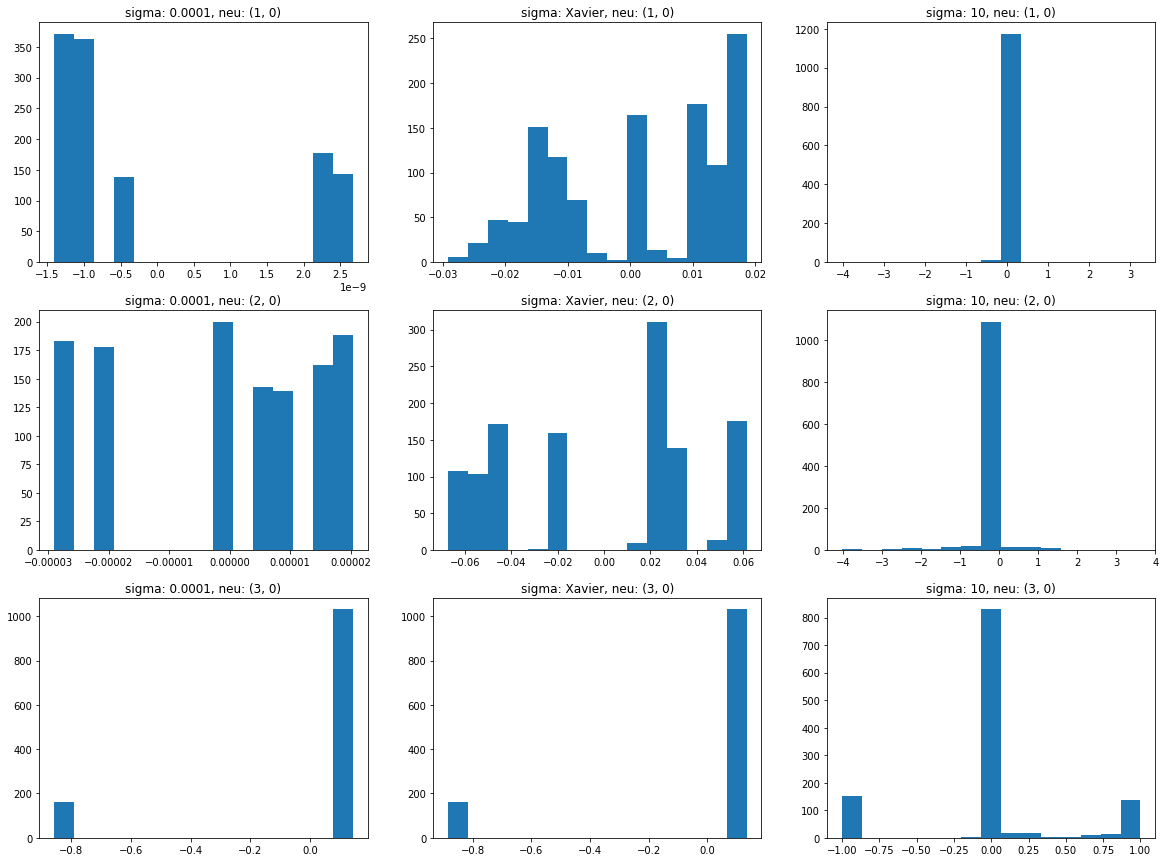

In [219]:
plt.figure(figsize=(20,15))
for num_neuron, neuron in enumerate(index_list):
    for num_sigma, sigma in enumerate([0.0001, 'Xavier', 10]):
        plt.subplot(3, 3, (num_neuron)*3+num_sigma+1)
        plt.title('sigma: '+str(sigma)+", neu: "+str(neuron))
        plt.hist(func(hist_g_by_sigma[sigma][0][neuron]), bins=15)
plt.savefig('flow_histback.png', bbox_inches='tight')
plt.show()

1000 done
all done
0.08635039627552032 0.09106890112161636 0.17626960575580597


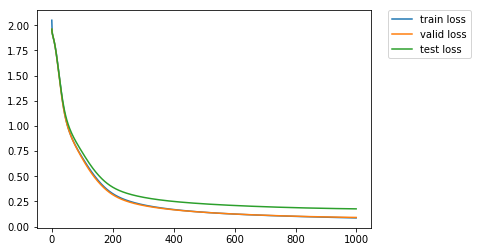

In [226]:
lrv = np.array([1.0])
learnGD(netFirstPointXavier,train_data,valid_data,test_data,lrv,1000,0.0,False)

1000 done
all done
0.08635039627552032 0.09106890112161636 0.17626960575580597


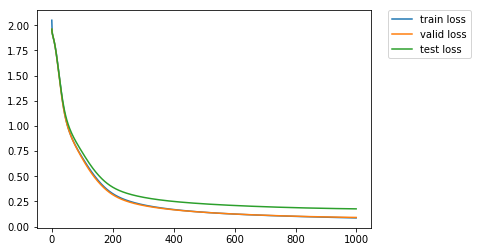

In [227]:
lrv = np.array([1.0])
learnGD(netFirstPointXavier,train_data,valid_data,test_data,lrv,1000,0.0,False)

1000 done
all done
1.937527060508728 1.9513543844223022 1.9542053937911987


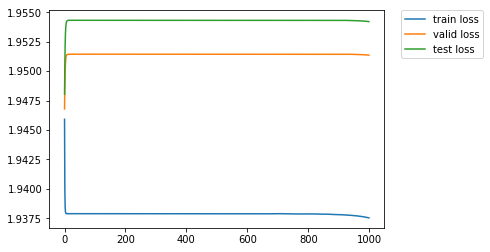

In [228]:
lrv = np.array([1.0])
learnGD(netSmall,train_data,valid_data,test_data,lrv,1000,0.0,False)

1000 done
all done
0.8104719519615173 1.0914069414138794 1.5107163190841675


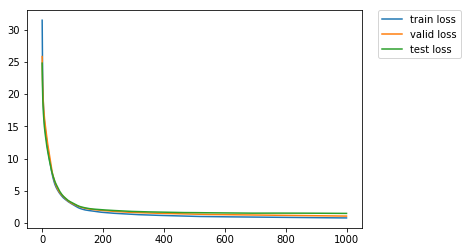

In [229]:
lrv = np.array([1.0])
learnGD(netBig,train_data,valid_data,test_data,lrv,1000,0.0,False)

In [255]:
gdnet = algorithms.GradientDescent(
    [
        layers.Input(11),
        layers.Sigmoid(20, weight=np.random.rand(11,20))#init.Normal(0.0, 0.1)),
        layers.Sigmoid(10, weight=np.random.rand(20,10))#init.Normal(0.0, 0.1)),
        layers.Softmax(7, weight=np.random.rand(10,7))#init.Normal(0.0, 0.1))
    ],
    error='categorical_crossentropy',
    shuffle_data=False,
    show_epoch=50,
    verbose=True
)
gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
plots.error_plot(gdnet)


Main information

[ALGORITHM] GradientDescent

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 50
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.38 seconds


In [314]:
from scipy.stats import truncnorm
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
Normal_U = get_truncated_normal(mean=8, sd=2, low=1, upp=10)


class raspU(init.Initializer):
    def __init__(self, sig, a, b):
        self.sig = sig
        self.a = a
        self.b = b

    def sample(self, shape):
        return np.random.uniform(-math.sqrt(self.sig * self.sig * 12 / 4), math.sqrt(self.sig * self.sig *  12 / 4), (self.a, self.b))
    
class raspN(init.Initializer):
    def __init__(self, sig, a, b):
        self.sig = sig
        self.a = a
        self.b = b

    def sample(self, shape):
        return np.random.normal(0, self.sig, (self.a, self.b))
    
class raspTN(init.Initializer):
    def __init__(self, sig, a, b):
        self.sig = sig
        self.a = a
        self.b = b

    def sample(self, shape):
        X = get_truncated_normal(mean=0, sd=self.sig, low=-3, upp=3)
        return X.rvs((self.a, self.b))

0.0918754197871
0.0517159737903
0.105107207033
0.0365362797693


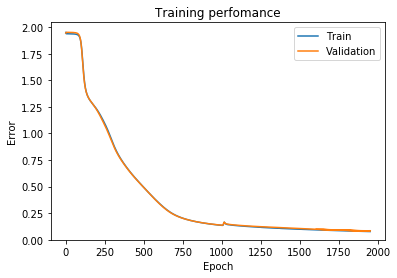

In [321]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspU(0.05, 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspU(0.05, 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspU(0.05, 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#Univers 0.1

0.0721023458343
0.0468154417022
0.0868031944728
0.035751072932


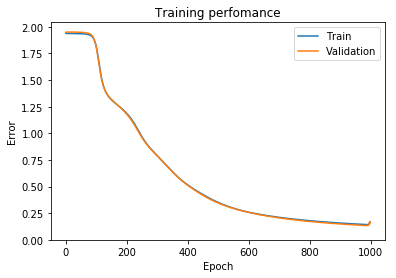

In [322]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspN(0.05, 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspN(0.05, 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspN(0.05, 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#Normal 0.1

0.0802481660422
0.0343263435422
0.0929387184991
0.0173729193171


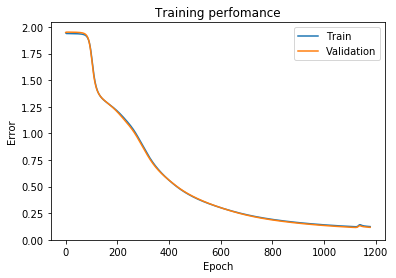

In [323]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspTN(0.05, 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspTN(0.05, 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspTN(0.05, 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#TN 0.1

0.911110012586
1.50096645319
1.40606487347
1.86246567994


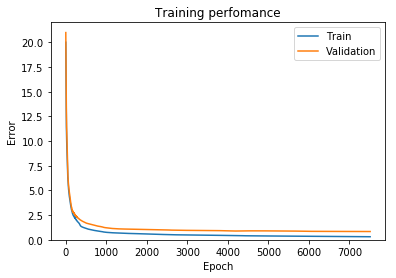

In [324]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspU(10.0, 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspU(10.0, 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspU(10.0, 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#Univers 10

0.31421977514
0.0638820528272
0.7219037564
0.117812375533


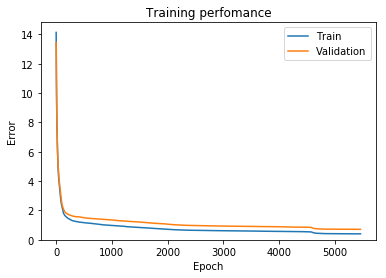

In [325]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspN(10.0, 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspN(10.0, 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspN(10.0, 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#Normal 10

0.031969673507
0.0027659131346
0.0925421215503
0.0160296124059


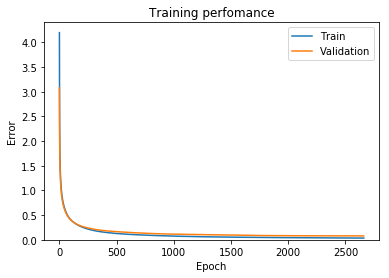

In [326]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspTN(10.1, 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspTN(10.1, 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspTN(10.1, 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#TN 10

0.0588380092492
0.0165131859913
0.0709843149115
0.00889101740901


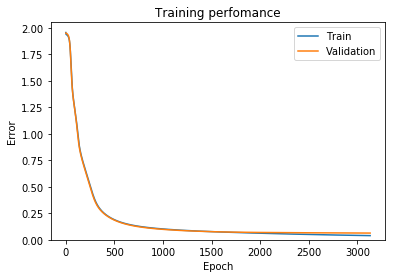

In [327]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspU( 5 / 3 * 2.0 / 31.0 , 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspU( 5 / 3 * 2.0 / 30.0 , 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspU( 5 / 3 * 2.0 / 17.0 , 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#TN 10

0.0559863039232
0.0366387868543
0.0815365839246
0.021195892369


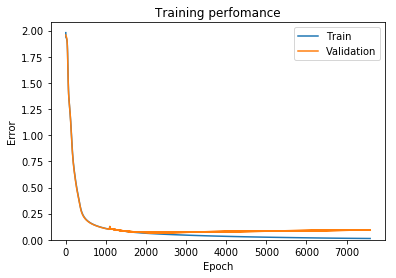

In [328]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspN( 5 / 3 * 2.0 / 31.0 , 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspN( 5 / 3 * 2.0 / 30.0 , 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspN( 5 / 3 * 2.0 / 17.0 , 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#TN 10

0.0559315809476
0.040272454256
0.085364402689
0.0166330105321


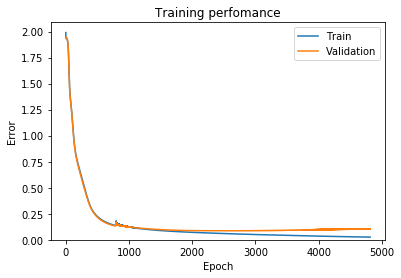

In [329]:
train__ = []
valid__ = []
for i in range(7):
    gdnet = algorithms.GradientDescent(
        [
            layers.Input(11),
            layers.Sigmoid(20, weight=raspTN( 5 / 3 * 2.0 / 31.0 , 11, 20)),#init.Normal(0.0, 0.1)),
            layers.Sigmoid(10, weight=raspTN( 5 / 3 * 2.0 / 30.0 , 20, 10)),#init.Normal(0.0, 0.1)),
            layers.Softmax(7, weight=raspTN( 5 / 3 * 2.0 / 17.0 , 10, 7)),#init.Normal(0.0, 0.1))
        ],
        step = 1.0,
        error='categorical_crossentropy',
        shuffle_data=False,
        #show_epoch=50,
        #verbose=True
    )
    gdnet.train(learn_params, learn_target, validation_params, validation_target, epochs=10000, epsilon = 0.00001)
    train__.append(gdnet.errors[-1])
    valid__.append(gdnet.validation_errors[-1])
print(np.mean(train__))
print(np.std(train__))
print(np.mean(valid__))
print(np.std(valid__))
plots.error_plot(gdnet)
#TN 10

In [331]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from IPython import display

import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader


np.random.seed(11)

IN_SIZE = 50
num_neuro_1 = 20
num_neuro_2 = 10
num_neuro_3 = 10

RES_DIR = './PUNKT_4_16/'
DATA_DIR = './CCPP/'
HOME_DIR = './'
use_gpu = False

ImportError: cannot import name 'lr_scheduler'

In [334]:
dfAllReady.to_csv('data.csv')

In [335]:
FEATURES_INDEX

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [336]:
LABEL_INDEX

0


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 50
[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 50
[OPTION] shuffle_data = True
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.82 seconds

Start training

[TRAINING DATA] shapes: (1193, 11)
[TEST DATA] shapes: (596, 11)
[TRAINING] Epsilon: 1e-05, Max epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           0 |      1.9836 |      1.9571 |       64 ms |


|          50 |      1.2864 |      1.2823 |       40 ms |


|         100 |     0.60503 |     0.59363 |       31 ms |


|         150 |     0.44651 |     0.42427 |       28 ms |


|         200 |     0.28045 |     0.26735 |       32 ms |


|         250 |     0.20334 |     0.19591 |       43 ms |


|         300 |     0.16165 |     0.16183 |       24 ms |


[TRAIN] Epoch #344 interrupted. Network converged.
|         344 |      0.1367 |     0.13535 |       20 ms |
---------------------------------------------------------



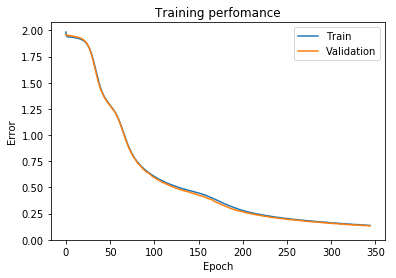

In [380]:
stepnet=algorithms.MinibatchGradientDescent(
     connection=[
         layers.Input(11),
         layers.Sigmoid(20, weight=init.XavierNormal(), bias=init.XavierNormal()),
         layers.Sigmoid(20, weight=init.XavierNormal(), bias=init.XavierNormal()),
         layers.Sigmoid(10, weight=init.XavierNormal(), bias=init.XavierNormal()),
         layers.Softmax(7, weight=init.XavierNormal(), bias=init.XavierNormal()),
     ],
    
     error='categorical_crossentropy',
   
     verbose=True,
     #epoch_end_signal=signal,
     shuffle_data=True,
     show_epoch=50,
     batch_size = 50
)
stepnet.train(learn_params, learn_target, validation_params, validation_target, epochs=5000, epsilon=0.00001)
plots.error_plot(stepnet)

In [381]:
from sklearn import metrics
y_predicted_learn = stepnet.predict(train_data[:,FEATURES_INDEX]).argmax(axis=1)
y_learn = np.asarray(oneHot(train_data[:,LABEL_INDEX]).argmax(axis=1)).reshape(train_data.shape[0])
print(metrics.classification_report(y_learn, y_predicted_learn))
score = metrics.accuracy_score(y_learn, y_predicted_learn)
print("Validation accuracy: {:.2%}".format(score))

from sklearn import metrics
y_predicted_test = stepnet.predict(test_data[:,FEATURES_INDEX]).argmax(axis=1)
y_test = np.asarray(oneHot(test_data[:,LABEL_INDEX]).argmax(axis=1)).reshape(test_data.shape[0])
print(metrics.classification_report(y_test, y_predicted_test))
score = metrics.accuracy_score(y_test, y_predicted_test)
print("Validation accuracy: {:.2%}".format(score))

Time: 0:00:00 |N/A%|                                           | ETA:  --:--:--

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       162
          1       0.99      1.00      1.00       139
          2       0.90      0.94      0.92       188
          3       0.98      0.93      0.95       178
          4       0.89      0.89      0.89       200
          5       0.99      0.99      0.99       183
          6       1.00      1.00      1.00       143

avg / total       0.96      0.96      0.96      1193

Validation accuracy: 95.81%
             precision    recall  f1-score   support

          0       1.00      0.97      0.98        32
          1       1.00      1.00      1.00        29
          2       0.74      0.96      0.84        24
          3       0.85      0.74      0.79        31
          4       0.68      0.63      0.66        30
          5       0.96      0.96      0.96        27
          6       1.00      1.00      1.00        26

avg / total       0.89      0.89      0.89       199

Validation a

In [382]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score
import collections
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[159   0   0   0   3   0   0]
 [  0 139   0   0   0   0   0]
 [  0   0 176   0  12   0   0]
 [  1   1   1 166   8   1   0]
 [  0   0  19   3 178   0   0]
 [  0   0   0   1   0 182   0]
 [  0   0   0   0   0   0 143]]
Confusion matrix, without normalization
[[31  0  0  0  1  0  0]
 [ 0 29  0  0  0  0  0]
 [ 0  0 23  0  1  0  0]
 [ 0  0  0 23  7  1  0]
 [ 0  0  8  3 19  0  0]
 [ 0  0  0  1  0 26  0]
 [ 0  0  0  0  0  0 26]]


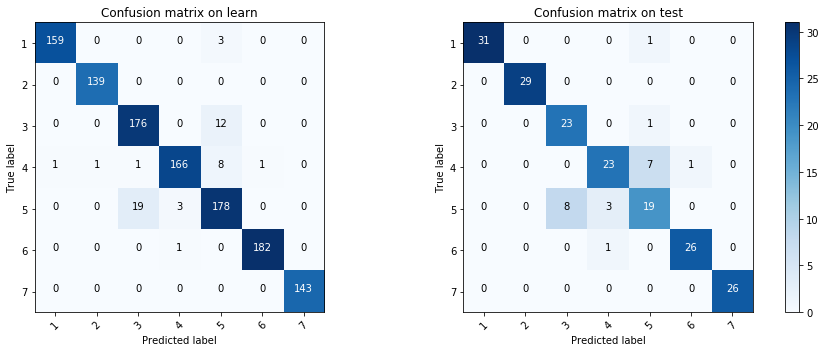

In [383]:
plt.figure(figsize=(15,5))

cnf_matrix = confusion_matrix(y_learn, y_predicted_learn)
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=['1', '2','3','4','5','6','7'], title='Confusion matrix on learn')
    
cnf_matrix = confusion_matrix(y_test, y_predicted_test)
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=['1', '2','3','4','5','6','7'], title='Confusion matrix on test')
plt.savefig('matrix_without_norm05.png', bbox_inches='tight')

Normalized confusion matrix
[[ 0.98148148  0.          0.          0.          0.01851852  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.93617021  0.          0.06382979  0.          0.        ]
 [ 0.00561798  0.00561798  0.00561798  0.93258427  0.04494382  0.00561798
   0.        ]
 [ 0.          0.          0.095       0.015       0.89        0.          0.        ]
 [ 0.          0.          0.          0.00546448  0.          0.99453552
   0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.        ]]
Normalized confusion matrix
[[ 0.96875     0.          0.          0.          0.03125     0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.95833333  0.          0.04166667  0.          0.        ]
 [ 0.          0.          0.          0.74193548  0.22580645  0.0322

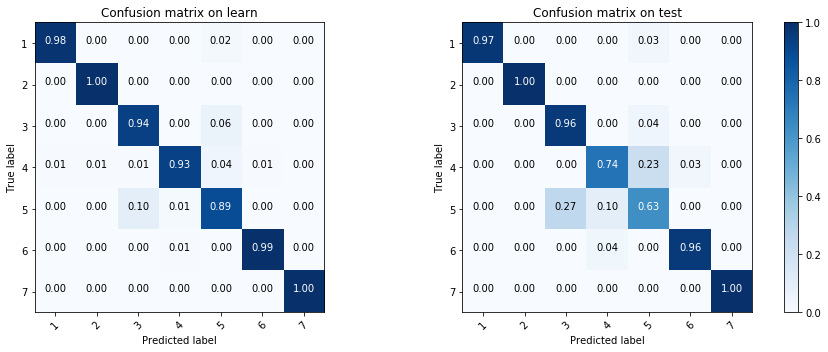

In [384]:
plt.figure(figsize=(15,5))

cnf_matrix = confusion_matrix(y_learn, y_predicted_learn)
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=['1', '2','3','4','5','6','7'], title='Confusion matrix on learn',normalize=True)
    
cnf_matrix = confusion_matrix(y_test, y_predicted_test)
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=['1', '2','3','4','5','6','7'], title='Confusion matrix on test',normalize=True)
plt.savefig('matrix_without_norm05.png', bbox_inches='tight')

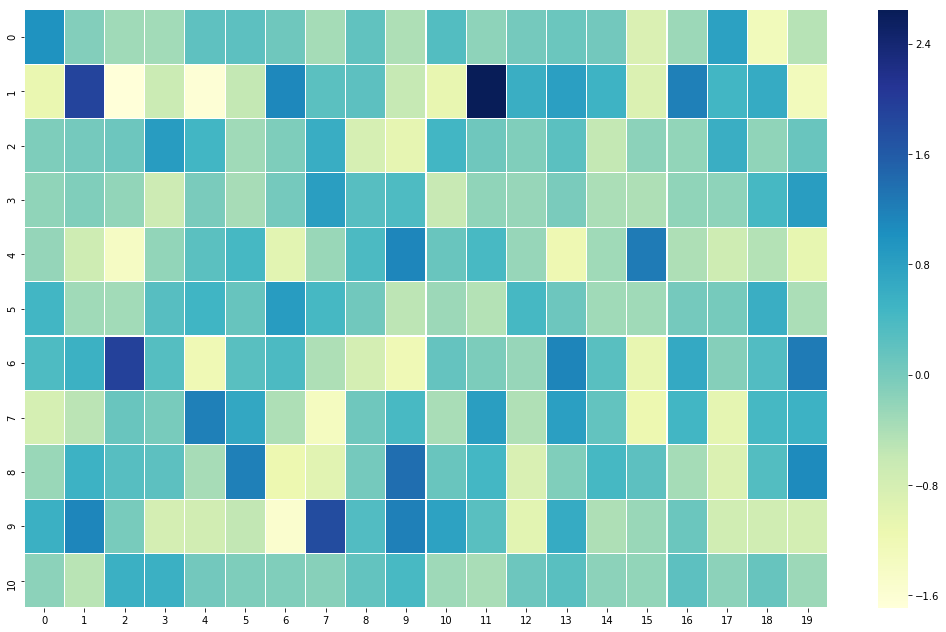

In [385]:
feature_impact = stepnet.layers[1].weight.get_value()
plt.figure(figsize=(18,11))
sns.heatmap(feature_impact, linewidths=0.1, cmap="YlGnBu")
plt.savefig('feature_impact_heat.png', bbox_inches='tight')

In [361]:
feature_impact.shape

(11, 20)